# Julia Notebook for _Gauges and Accelerated Optimization over Smooth and/or Strongly Convex Sets_
### Ning Liu, Benjamin Grimmer

This notebook follows along the idea presented in _Gauges and Accelerated Optimization over Smooth and/or Strongly Convex Sets_. We present implementations of algorithms in Section 4, and apply them to feasibility problems and constrained optimization.   

## $p$-norm Ellipsoid Feasibility Problems

We implement subgradient methods, generalized gradient methods, accelerated generalized gradient methods and level methods given smooth or strongly convex structure.
The following table is the tuned parameters $\eta$\, note for accelerated method we have two parameters $L$ and $\mu$.

| Algorithm\(p1,p2) | (1.5, 1.8) | (2,2) | (3,4) |
| --- | --- | --- | --- |
| Subgrad Const  |  .18 | .23 | .12 |
| Subgrad 1/Sqrt(k)  |  1.4 | 1.0 | .43 |
| GenGrad Const  |  .35 | .40 | .18 |
| GenGrad 1/Sqrt(k)  |  2.1 | 1.6 | .12 |
| GenGrad Accel  | 8.0, .12 | 3.6, .12 | 8.2, .13 |

In [13]:
using Roots
using LinearAlgebra
using ForwardDiff
using Distributions
using Random
using PyPlot


In [14]:
# Gauge 
function gauge(f, x)
    lambda=1.0
    if norm(x)<=0.00000001
    gamma = 0
    else
        if f(x/lambda)-1>0
            while f(x/lambda)-1>0
                lambda = 2 * lambda
            end
            if f(x/lambda)-1==0
                gamma = lambda
            else
                g = c -> f(x/c)-1
                gamma = find_zero(g, (lambda/2,lambda), Bisection())
            end
        elseif f(x/lambda)-1 < 0
            while f(x/lambda)-1<0
                lambda = 0.5 * lambda
            end
            if f(x/lambda)-1==0
                gamma = lambda
            else 
                g = c -> f(x/c)-1
                gamma = find_zero(g, (lambda,2*lambda), Bisection())
            end
        else 
            gamma = lambda
        end
    end
    return gamma
end

# Half gauge squared 
function half_gauge_squared(f,x)
    return 0.5*gauge(f,x)^2
end

# Subgradient of gauge 
function subgrad_gauge(f,gradf,x)
    if norm(x)<=0.00000001
        return zeros(length(x))
    else
        y = x/gauge(f,x)
        n = gradf(y)
        return n/dot(n,y)
    end
end

# Subgradient of half gauge squared
function subgrad_half_gauge_squared(f,gradf,x)
    if norm(x)<=0.00000001
        return zeros(dim(x))
    else
        val=gauge(f,x)
        y = x/val
        n = gradf(y)
        return val*n/dot(n,y)
    end
end

# Translated gauge
function gauge(f, x, e)
    trans_f = y -> f(y+e)
    return gauge(trans_f, x-e)
end

# Translated half gauge squared
function half_gauge_squared(f,x,e)
    trans_f = y->f(y+e)
    return half_gauge_squared(trans_f, x-e)
end

# Translated subgradient of gauge
function subgrad_gauge(f, gradf, x, e)
    trans_f = y -> f(y+e)
    trans_gradf = y -> gradf(y+e)
    return subgrad_gauge(trans_f, trans_gradf, x-e)
end

# Translated subgradient of half gauge squared
function subgrad_half_gauge_squared(f, gradf, x, e)
    trans_f = y -> f(y+e)
    trans_gradf = y -> gradf(y+e)
    return subgrad_half_gauge_squared(trans_f, trans_gradf, x-e)
end





subgrad_half_gauge_squared (generic function with 2 methods)

In [15]:
function radial_subgradient(f1, f2, gradf1, gradf2, xk, eta, max_iter = 10000)
    
    xk = x0
    ret = zeros(max_iter)
    num_iter = 1
    
    while num_iter<=max_iter
        f1k = f1(xk)
        f2k = f2(xk)
        
        if f1k >= f2k
            ret[num_iter] = f1k
            grad = gradf1(xk)
        else
            ret[num_iter] = f2k
            grad = gradf2(xk)
        end

        xk = xk-eta*grad
        num_iter +=1
    end
    return ret, num_iter-1
end

function radial_subgradient_sqrt(f1, f2, gradf1, gradf2, xk, eta, max_iter = 10000)
    
    xk = x0
    ret = zeros(max_iter)
    num_iter = 1
    
    while num_iter<=max_iter
        f1k = f1(xk)
        f2k = f2(xk)
        
        if f1k >= f2k
            ret[num_iter] = f1k
            grad = gradf1(xk)
        else
            ret[num_iter] = f2k
            grad = gradf2(xk)
        end

        xk = xk-eta/sqrt(num_iter+10)*grad
        
        num_iter +=1
    end
    return ret, num_iter-1
end

function radial_subgradient_linear(f1, f2, gradf1, gradf2, xk, eta, max_iter = 10000)
    
    xk = x0
    ret = zeros(max_iter)
    num_iter = 1
    
    while num_iter<=max_iter
        f1k = f1(xk)
        f2k = f2(xk)
        
        if f1k >= f2k
            ret[num_iter] = f1k
            grad = gradf1(xk)
        else
            ret[num_iter] = f2k
            grad = gradf2(xk)
        end

        xk = xk-eta/(num_iter+10)*grad
        num_iter +=1
    end
    return ret, num_iter-1
end

function dx_min_max(f1, f2, gradf1, gradf2, xk, alpha)

    a1 = gradf1(xk)
    a2 = gradf2(xk)
    b1 = f1(xk)
    b2 = f2(xk)
    b = max(b1, b2)
    
    dx1 = -1 * a1 * alpha
    dx2 = -1 * a2 * alpha

    if b1+dot(a1,dx1) > b2+dot(a2,dx1)
        dx = dx1
    elseif b1+dot(a1,dx2) < b2+dot(a2,dx2)
        dx = dx2
    else
        theta = (1/alpha * (b2-b1)+dot(a1-a2,a1))/norm(a1-a2,2)^2
        dx = -1 * ((1-theta) * a1 + theta * a2) * alpha
    end
    return dx, b
end

function radial_gradient(f1, f2, gradf1, gradf2, x0, eta, max_iter = 10000)
    xk = x0
    ret = zeros(max_iter)
    num_iter = 1
    
    while num_iter <= max_iter
        dx, ret[num_iter] = dx_min_max(f1, f2, gradf1, gradf2, xk, eta)

        xk = xk + dx
        num_iter +=1
        
    end
    return ret, num_iter-1
end

function radial_gradient_sqrt(f1, f2, gradf1, gradf2, x0, eta, max_iter = 10000)
    xk = x0
    ret = zeros(max_iter)
    num_iter = 1
    
    
    while num_iter<=max_iter
    alpha = eta/sqrt(num_iter+10)
    dx, ret[num_iter] = dx_min_max(f1, f2, gradf1, gradf2, xk, alpha)
        
    xk = xk+ dx
    num_iter += 1
    end
    return ret, num_iter-1
end



function radial_gradient_linear(f1, f2, gradf1, gradf2, x0, eta, max_iter = 10000)
    xk = x0
    ret = zeros(max_iter)
    num_iter = 1
    
    
    while num_iter<=max_iter
        alpha = eta/(num_iter+10)
        dx, ret[num_iter] = dx_min_max(f1, f2, gradf1, gradf2, xk, alpha)
        
        xk = xk+ dx
        num_iter += 1
    end
    return ret, num_iter-1
end



function level_method(f1, f2, gradf1, gradf2, x0, m, max_iter = 10000)
    xk = x0
    ret = zeros(max_iter)
    num_iter = 1
    
    while num_iter<=max_iter
        
        a1 = gradf1(xk)
        a2 = gradf2(xk)
        b1 = f1(xk)
        b2 = f2(xk)
        b = max(b1, b2)

        dx1 = -(b1-m)/norm(a1,2)^2*a1
        dx2 = -(b2-m)/norm(a2,2)^2*a2

        if b1 + dot(a1,dx1) > b2 + dot(a2,dx1)
            dx = dx1
        elseif b1 + dot(a1,dx2) < b2 + dot(a2,dx2)
            dx = dx2
        else
            lambda = inv([norm(a1,2)^2 dot(a1,a2); dot(a1,a2) norm(a2,2)^2])*[m-b1; m-b2]
            dx = lambda[1]*a1+lambda[2]*a2
        end
        
        ret[num_iter] = b
        xk = xk + dx
        num_iter +=1
    end
    return ret, num_iter-1
end



function radial_accelerate(f1, f2, gradf1, gradf2, x0, L, mu, max_iter = 10000)
    xk = x0
    ret = zeros(max_iter)
    num_iter = 1
    q = mu/L
    
    alpha_prev = 0.5
    alpha_curr = (q - alpha_prev^2 + sqrt((q-alpha_prev^2)^2 + 4 * (alpha_prev)^2))/2
    beta = alpha_prev*(1 - alpha_prev)/(alpha_curr+alpha_prev^2)
    y_prev = x0
    
    while num_iter <= max_iter
        dx, ret[num_iter] = dx_min_max(f1, f2, gradf1, gradf2, xk, 1/L)

            
        y_curr = xk + dx 
        xk = y_curr + beta*(y_curr-y_prev)
        y_prev = y_curr
        
        alpha_tem = alpha_curr
        alpha_curr = (q - alpha_curr^2 + sqrt((q-alpha_curr^2)^2 + 4 * (alpha_curr)^2))/2
        alpha_prev = alpha_tem
        
        beta = alpha_prev*(1 - alpha_prev)/(alpha_curr+alpha_prev^2)
        num_iter +=1
    end
    return ret, num_iter-1
end

function conjugate_gradient(A, b, x0, max_iter)
    xk = x0
    rk = b-A*xk
    pk = rk
    
    num_iter = 1

    while num_iter <= max_iter
        apk = A*pk
        rks = dot(rk, rk)
        if rks<0.0000001
            break 
        end
        alpha = rks/dot(pk, apk)
        
        xk = xk + alpha*pk
        rk = rk - alpha*apk
        beta = dot(rk, rk)/rks
        pk = rk + beta*pk

        num_iter+=1
    end
    return xk
end



function cleanData(data)
    for i in 2:length(data)
        data[i] = min(data[i-1], data[i])
    end
    return data
end

cleanData (generic function with 1 method)

### Strongly Convex Setting(1<p<2)

In [16]:
# Generating random test data
p3 = 1.5
p4 = 1.8

m = 1600
n = 1600

Random.seed!(1234)
x0 = zeros(n)

x_true = randn(n)
A3 = randn(m,n)
A4 = randn(m,n)
d3 = PGeneralizedGaussian(0,1/sqrt(2),p3)
d4 = PGeneralizedGaussian(0,1/sqrt(2),p4)
epsilon3 = rand(d3,m)
epsilon4 = rand(d4,m)

# Generating data samples to get b 
N = 10000
i = 1
norm3 = zeros(N)
norm4 = zeros(N)
while i <= N
    norm3[i] = norm(epsilon3, p3)
    norm4[i] = norm(epsilon4, p4)
    i+=1
end
tau3 = quantile(norm3, 0.975)
tau4 = quantile(norm4, 0.975)
A3 = A3/tau3
A4 = A4/tau4
b3 = A3*x_true + epsilon3/tau3
b4 = A4*x_true + epsilon4/tau4

# Computing a point e in the constraint set
e3 = conjugate_gradient(A3'*A3, A3'*b3, x0, 30)
e4 = conjugate_gradient(A4'*A4, A4'*b4, x0, 30)

println("tau3=", tau3)
println("tau4=", tau4)

# Define objective function f and subgradient g
h3 = x -> norm(A3*x-b3,p3)^p3
h4 = x -> norm(A4*x-b4,p4)^p4
f3 = x -> half_gauge_squared(h3,x,e3)
f4 = x -> half_gauge_squared(h4,x,e4)
gh3 = x -> ForwardDiff.gradient(h3, x)
gh4 = x -> ForwardDiff.gradient(h4, x)
gf3 = x -> subgrad_half_gauge_squared(h3,gh3,x,e3)
gf4 = x -> subgrad_half_gauge_squared(h4,gh4,x,e4)


tau3=72.69152775892556
tau4=30.30522856287637


#31 (generic function with 1 method)

In [17]:
# Getting the optimal objective value
sc_long, iter_long= radial_gradient_sqrt(f3,f4,gf3,gf4,x0,2.1,2000)
sc_long = cleanData(sc_long)

LoadError: InterruptException:

In [18]:
sc1, iter21= radial_subgradient(f3,f4,gf3,gf4,x0,0.23,200)
sc2, iter22= radial_subgradient_sqrt(f3,f4,gf3,gf4,x0,1.4,200)
# sc3, iter23= radial_subgradient_linear(f3,f4,gf3,gf4,x0,4.7,200)
sc4, iter24= radial_gradient(f3, f4, gf3, gf4, x0, 0.35, 200)
sc5, iter25= radial_gradient_sqrt(f3, f4, gf3, gf4, x0, 2.1, 200)
# sc6, iter26= radial_gradient_linear(f3, f4, gf3, gf4, x0, 7.7, 200)
sc7, iter27= radial_accelerate(f3,f4,gf3,gf4,x0,8.0,0.12,200)
sc8, iter28= level_method(f3,f4,gf3,gf4,x0,sc_long[2000],200)
sc9, iter29= level_method(f3,f4,gf3,gf4,x0,1,200)


LoadError: InterruptException:

In [19]:
sc1 = cleanData(sc1)
sc2 = cleanData(sc2)
# sc3 = cleanData(sc3)
sc4 = cleanData(sc4)
sc5 = cleanData(sc5)
# sc6 = cleanData(sc6)
sc7 = cleanData(sc7)
sc8 = cleanData(sc8)
sc9 = cleanData(sc9)

LoadError: UndefVarError: sc1 not defined

In [20]:
PyPlot.semilogy(1:iter21, ones(200)*(1-sc_long[2000]), color="black", linestyle = "solid")
PyPlot.semilogy(1:iter21, sc1.-sc_long[2000], label = "Rad_Subgrad", linestyle = "dotted")
PyPlot.semilogy(1:iter22, sc2.-sc_long[2000], label = "Rad_Subgrad_1/sqrt(k)", linestyle = "dotted")
# PyPlot.semilogy(1:iter23, sc3.-sc_long[2000], label = "Rad_Subgrad_1/k")
PyPlot.semilogy(1:iter24, sc4.-sc_long[2000], label = "Rad_Grad", linestyle = "dashed")
PyPlot.semilogy(1:iter25, sc5.-sc_long[2000], label = "Rad_Grad_1/sqrt(k)", linestyle = "dashed")
# PyPlot.semilogy(1:iter26, sc6.-sc_long[2000], label = "Rad_Grad_1/k")
PyPlot.semilogy(1:iter27, sc7.-sc_long[2000], label = "Rad_Accel", linestyle = "dashed")
PyPlot.semilogy(1:iter28, sc8.-sc_long[2000], label = "Level_Method_Opt", linestyle = "dashdot")
PyPlot.semilogy(1:iter29, sc9.-sc_long[2000], label = "Level_Method_1", linestyle = "dashdot")
# legend()


# ylim(1e-8,1e4)
xlabel("Iterations")
ylabel("Accuracy")

# savefig("strongly_convex1600")

LoadError: UndefVarError: iter21 not defined

### Smooth and Strongly convex setting (p=2)

In [5]:
# Generating random test data
p5 = 2
p6 = 2

m = 1600
n = 1600

Random.seed!(1234)

x0 = zeros(n)

x_true = randn(n)
A5 = randn(m,n)
A6 = randn(m,n)
d5 = PGeneralizedGaussian(0,1/sqrt(2),p5)
d6 = PGeneralizedGaussian(0,1/sqrt(2),p6)
epsilon5 = rand(d5,m)
epsilon6 = rand(d6,m)

# Generating data samples to get b
N = 10000
i = 1
norm5 = zeros(N)
norm6 = zeros(N)
while i <= N
    norm5[i] = norm(epsilon5, p5)
    norm6[i] = norm(epsilon6, p6)
    i+=1
end
tau5 = quantile(norm5, 0.975)
tau6 = quantile(norm6, 0.975)
A5 = A5/tau5
A6 = A6/tau6
b5 = A5*x_true + epsilon5/tau5
b6 = A6*x_true + epsilon6/tau6

# Computing a point e in the constraint set
e5 = conjugate_gradient(A5'*A5, A5'*b5, x0, 30)
e6 = conjugate_gradient(A6'*A6, A6'*b6, x0, 30)

println("tau5=", tau5)
println("tau6=", tau6)

# Define objective function f and subgradient g
h5 = x -> norm(A5*x-b5,p5)^p5
h6 = x -> norm(A6*x-b6,p6)^p6
f5 = x -> half_gauge_squared(h5,x,e5)
f6 = x -> half_gauge_squared(h6,x,e6)
gh5 = x -> 2*A5'*(A5*x-b5)
gh6 = x -> 2*A6'*(A6*x-b6)
gf5 = x -> subgrad_half_gauge_squared(h5,gh5,x,e5)
gf6 = x -> subgrad_half_gauge_squared(h6,gh6,x,e6)



tau5=32.71166068893601
tau6=34.51470752066359
128.65161949345247
7.704821811655459e-8


In [22]:
# Getting the optimal objective value
g_long3, iter_long3 = radial_accelerate(f5,f6,gf5,gf6,x0,3.6,0.12,2000)
g_long3 = cleanData(g_long3)

([1734.6722149422196, 428.10914406050335, 142.9269698566565, 75.78062838401183, 43.924695945278785, 28.59138692553549, 20.176978231534388, 13.897580223655313, 11.448928597621642, 8.17305280023004  …  0.2479969562767968, 0.24799695627679735, 0.24799695627679688, 0.24799695627679696, 0.24799695627679774, 0.24799695627679696, 0.24799695627679735, 0.24799695627679705, 0.2479969562767968, 0.24799695627679658], 2000)

In [23]:
g1, iter31 = radial_subgradient(f5,f6,gf5,gf6,x0,0.18,200)
g2, iter32 = radial_subgradient_sqrt(f5,f6,gf5,gf6,x0,1.0,200)
# g3, iter33 = radial_gradient_linear(f5,f6,gf5,gf6,x0,3.8,200)
g4, iter34 = radial_gradient(f5,f6,gf5,gf6,x0,0.40,200)
g5, iter35 = radial_gradient_sqrt(f5,f6,gf5,gf6,x0,1.6,200)
# g6, iter36 = radial_gradient_linear(f5,f6,gf5,gf6,x0,5.7,200)
g7, iter37 = radial_accelerate(f5,f6,gf5,gf6,x0,3.6,0.12,200)
g8, iter38 = level_method(f5,f6,gf5,gf6,x0,g_long3[2000],200)
g9, iter39 = level_method(f5,f6,gf5,gf6,x0,1,200)

([1734.6722149422196, 529.8784452361317, 173.10793995312613, 57.47732422656203, 22.776994536153445, 15.474771030030798, 9.911929874430516, 8.006239566380362, 4.8368668265076655, 3.958552171409796  …  1.0000000000000002, 0.9999999999999998, 1.0000000000000002, 0.9999999999999998, 1.0000000000000002, 0.9999999999999998, 1.0000000000000002, 0.9999999999999998, 1.0000000000000002, 0.9999999999999998], 200)

In [24]:
g1 = cleanData(g1)
g2 = cleanData(g2)
# g3 = cleanData(g3)
g4 = cleanData(g4)
g5 = cleanData(g5)
# g6 = cleanData(g6)
g7 = cleanData(g7)
g8 = cleanData(g8)
g9 = cleanData(g9)

200-element Vector{Float64}:
 1734.6722149422196
  529.8784452361317
  173.10793995312613
   57.47732422656203
   22.776994536153445
   15.474771030030798
    9.911929874430516
    8.006239566380362
    4.8368668265076655
    3.958552171409796
    2.303444985053471
    1.298405318422844
    1.0934690502180675
    ⋮
    0.9999999999999992
    0.9999999999999992
    0.9999999999999992
    0.9999999999999992
    0.9999999999999992
    0.9999999999999992
    0.9999999999999992
    0.9999999999999992
    0.9999999999999992
    0.9999999999999992
    0.9999999999999992
    0.9999999999999992

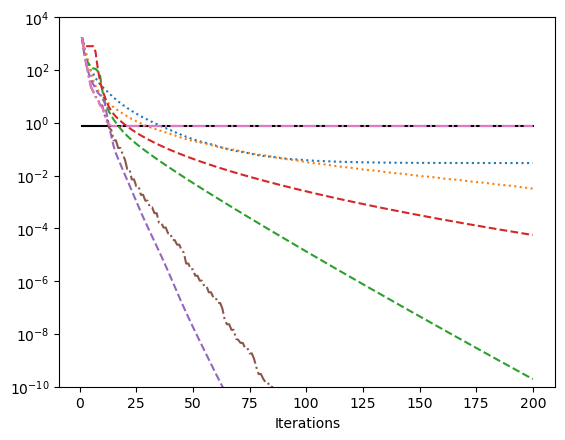

In [95]:
PyPlot.semilogy(1:iter31, ones(200)*(1-g_long3[2000]), color="black", linestyle = "solid")
PyPlot.semilogy(1:iter31, g1.-g_long3[2000], label = "Rad_Subgrad_Const", linestyle = "dotted")
PyPlot.semilogy(1:iter32, g2.-g_long3[2000], label = "Rad_Subgrad_1/sqrt(k)", linestyle = "dotted")
# PyPlot.semilogy(1:iter33, g3.-g_long3[2000], label = "Rad_Subgrad_1/k", linestyle = "solid")
PyPlot.semilogy(1:iter34, g4.-g_long3[2000], label = "Rad_Grad_Const", linestyle = "dashed")
PyPlot.semilogy(1:iter35, g5.-g_long3[2000], label = "Rad_Grad_1/sqrt(k)", linestyle = "dashed")
# PyPlot.semilogy(1:iter36, g6.-g_long3[2000], label = "Rad_Grad_1/k", linestyle = "dashed")
PyPlot.semilogy(1:iter37, g7.-g_long3[2000], label = "Rad_Accel", linestyle = "dashed")
PyPlot.semilogy(1:iter38, g8.-g_long3[2000], label = "Level_Method_Opt", linestyle = "dashdot")
PyPlot.semilogy(1:iter39, g9.-g_long3[2000], label = "Level_Method_1", linestyle = "dashdot")
# legend()

ylim(1e-10,1e4)
xlabel("Iterations")
# ylabel("Accuracy")

savefig("smooth_sconvex1600")

### Smooth Setting(p>2)

In [ ]:
# Generating random test data
p1 = 3
p2 = 4

m = 1600
n = 1600
Random.seed!(1234)

x0 = zeros(n)

x_true = randn(n)
A1 = randn(m,n)
A2 = randn(m,n)
d1 = PGeneralizedGaussian(0,1/sqrt(2),p1)
d2 = PGeneralizedGaussian(0,1/sqrt(2),p2)
epsilon1 = rand(d1,m)
epsilon2 = rand(d2,m)

# Generating data samples to get b
N = 10000
i = 1
norm1 = zeros(N)
norm2 = zeros(N)
while i <= N
    norm1[i] = norm(epsilon1, p1)
    norm2[i] = norm(epsilon2, p2)
    i+=1
end
tau1 = quantile(norm1, 0.975)
tau2 = quantile(norm2, 0.975)
A1 = A1/tau1
A2 = A2/tau2
b1 = A1*x_true + epsilon1/tau1
b2 = A2*x_true + epsilon2/tau2

# Computing a point e in the constraint set
e1 = conjugate_gradient(A1'*A1, A1'*b1, x0, 30)
e2 = conjugate_gradient(A2'*A2, A2'*b2, x0, 30)


println("tau1=", tau1)
println("tau2=", tau2)

# Define objective function f and subgradient g
h1 = x -> norm(A1*x-b1,p1)^p1
h2 = x -> norm(A2*x-b2,p2)^p2
f1 = x -> half_gauge_squared(h1,x,e1)
f2 = x -> half_gauge_squared(h2,x,e2)
gh1 = x -> ForwardDiff.gradient(h1, x)
gh2 = x -> ForwardDiff.gradient(h2, x)
gf1 = x -> subgrad_half_gauge_squared(h1,gh1,x,e1)
gf2 = x -> subgrad_half_gauge_squared(h2,gh2,x,e2)



In [ ]:
# Getting the optimal objective value
sm_long, iter_long= radial_accelerate(f1,f2,gf1,gf2,x0,8.2,0.13,2000)

In [ ]:
sm1, iter1= radial_subgradient(f1,f2,gf1,gf2,x0,0.12,200)
sm2, iter2= radial_subgradient_sqrt(f1,f2,gf1,gf2,x0,0.43,200)
# sm3, iter3= radial_subgradient_linear(f1,f2,gf1,gf2,x0,1.5,200)
sm4, iter4= radial_gradient(f1,f2,gf1,gf2,x0,0.18,200) 
sm5, iter5= radial_gradient_sqrt(f1,f2,gf1,gf2,x0,0.69,200)
# sm6, iter6= radial_gradient_linear(f1,f2,gf1,gf2,x0,2.5,200)
sm7, iter7= radial_accelerate(f1,f2,gf1,gf2,x0,8.2,0.13,200)
sm8, iter8= level_method(f1,f2,gf1,gf2,x0,sm_long[2000],200)
sm9, iter9= level_method(f1,f2,gf1,gf2,x0,1,200)


In [ ]:
sm1 = cleanData(sm1)
sm2 = cleanData(sm2)
# sm3 = cleanData(sm3)
sm4 = cleanData(sm4)
sm5 = cleanData(sm5)
# sm6 = cleanData(sm6)
sm7 = cleanData(sm7)
sm8 = cleanData(sm8)
sm9 = cleanData(sm9)

In [ ]:
PyPlot.semilogy(1:iter1, ones(200)*(1-sm_long[2000]), color="black", linestyle = "solid")
PyPlot.semilogy(1:iter1, sm1.-sm_long[2000], label = "Subgrad_Const", linestyle = "dotted")
PyPlot.semilogy(1:iter2, sm2.-sm_long[2000], label = "Subgrad_1/sqrt(k)", linestyle = "dotted")
# PyPlot.semilogy(1:iter3, sm3.-sm_long[2000], label = "Rad_Subgrad_1/k")
PyPlot.semilogy(1:iter4, sm4.-sm_long[2000], label = "GenGrad_Const", linestyle = "dashed")
PyPlot.semilogy(1:iter5, sm5.-sm_long[2000], label = "GenGrad_1/sqrt(k)", linestyle = "dashed")
# PyPlot.semilogy(1:iter6, sm6.-sm_long[2000], label = "Rad_Grad_1/k")
PyPlot.semilogy(1:iter7, sm7.-sm_long[2000], label = "GenGrad_Accel", linestyle = "dashed")
PyPlot.semilogy(1:iter8, sm8.-sm_long[2000], label = "Level_Proj_Opt", linestyle = "dashdot")
PyPlot.semilogy(1:iter9, sm9.-sm_long[2000], label = "Level_Proj_1", linestyle = "dashdot")
# legend()
legend(bbox_to_anchor=(1.0,1.0))

ylim(1e-10,1e4)
xlabel("Iterations")
# ylabel("Accuracy")

savefig("smooth_1600", bbox_inches="tight")

## Trust Region Optimization Problems

In [5]:
using Convex
using SCS
using LinearAlgebra
using Random
using Dates
using JuMP
using Mosek
using MosekTools
using COSMO
using Gurobi
using Interpolations

In [6]:
function radial_accelerate(f1, f2, x0, L, mu, max_iter = 10000)
    xk = x0
    ret = zeros(max_iter)
    num_iter = 1
    q = mu/L
    
    alpha_prev = 0.5
    alpha_curr = (q - alpha_prev^2 + sqrt((q-alpha_prev^2)^2 + 4 * (alpha_prev)^2))/2
    beta = alpha_prev*(1 - alpha_prev)/(alpha_curr+alpha_prev^2)
    y_prev = x0
    
    while num_iter <= max_iter
        b1, a1 = f1(xk)
        b2, a2 = f2(xk)
        b = max(b1, b2)
        ret[num_iter] = -1/sqrt(2*b)
        
        dx1 = -1 * a1/L
        dx2 = -1 * a2/L

        if b1 + dot(a1,dx1) > b2 + dot(a2,dx1)
            dx = dx1
        elseif b1 + dot(a1,dx2) < b2 + dot(a2,dx2)
            dx = dx2
        else
            theta = (L * (b2-b1)+dot(a1-a2,a1))/norm(a1-a2,2)^2
            dx = -1*((1-theta) * a1 + theta * a2)/L
        end

        y_curr = xk + dx 
        xk = y_curr + beta*(y_curr-y_prev)
        y_prev = y_curr

        alpha_tem = alpha_curr
        alpha_curr = (q - alpha_curr^2 + sqrt((q-alpha_curr^2)^2 + 4 * (alpha_curr)^2))/2
        alpha_prev = alpha_tem
        
        beta = alpha_prev*(1 - alpha_prev)/(alpha_curr+alpha_prev^2)
        num_iter +=1
    end
    return ret, num_iter-1
end

function radial_accelerate(f1, f2, x0, L, mu, seconds, samples)
    xk = x0
    ret = zeros(samples)
    i = 1
    q = mu/L
    
    t0 = round(Int64, time() * 1000)
    ti = t0
    tn = t0 + 1000*seconds
    timestep=0
    
    alpha_prev = 0.5
    alpha_curr = (q - alpha_prev^2 + sqrt((q-alpha_prev^2)^2 + 4 * (alpha_prev)^2))/2
    beta = alpha_prev*(1 - alpha_prev)/(alpha_curr+alpha_prev^2)
    y_prev = x0 
    
    while ti <= tn
        b1, a1 = f1(xk)
        b2, a2 = f2(xk)
        b = max(b1, b2)
        

        
        dx1 = -1 * a1/L
        dx2 = -1 * a2/L

        if b1 + dot(a1,dx1) > b2 + dot(a2,dx1)
            dx = dx1
        elseif b1 + dot(a1,dx2) < b2 + dot(a2,dx2)
            dx = dx2
        else
            theta = (L * (b2-b1)+dot(a1-a2,a1))/norm(a1-a2,2)^2
            dx = -1*((1-theta) * a1 + theta * a2)/L
        end

        y_curr = xk + dx 
        xk = y_curr + beta*(y_curr-y_prev)
        y_prev = y_curr

        alpha_tem = alpha_curr
        alpha_curr = (q - alpha_curr^2 + sqrt((q-alpha_curr^2)^2 + 4 * (alpha_curr)^2))/2
        alpha_prev = alpha_tem
        
        beta = alpha_prev*(1 - alpha_prev)/(alpha_curr+alpha_prev^2)
        
        timestep = min(ceil(Int64, samples*(ti-t0)/(tn-t0))+1,samples)
        ret[timestep] = -1/sqrt(2*b)
        ti = round(Int64, time() * 1000)
        i +=1
    end
    return ret, i-1
end


function cleanData(data)
    for i in 2:length(data)
        data[i] = min(data[i-1], data[i])
    end
    return data
end

cleanData (generic function with 1 method)

### p = 2-norm Ellipsoid Constrained Optimization

We implement our radial methods on three different data dimensions (400,200), (800,400), (1600,800), comparing with solvers Gurobi, Mosek, COSMO, SOS.

The following table gives tuned parameters L and $\mu$ of accelerated methods.

| Dimension (n,m) | (400, 200) | (800,400) | (1600,800) |
| --- | --- | --- | --- |
| Parameter (L, $\mu$)  |  (110,1.2e-3) | (160, 8.1e-4) | (440,4.4e-4) |

In [905]:
# Dimensions
n = 1600
m = 800

# Generating random data test
x0 = zeros(n)
Random.seed!(123)
P = randn(n,n)
Q = P'*P
c = randn(n,1)

A = randn(m, n)
b = A*randn(n) + 1/m*randn(m)

# Computing a point e in the constraint set
e = conjugate_gradient(A'*A, A'*b, x0, 30)

# Translating original problem by e
b_e = b-A*e
c_e = c+Q*e

# Getting half upper radial squared function and its gradient of objective
function rad_obj_grad1(x)
    Px = P*x
    cx = dot(c_e,x)
    f_upradial = (cx+1+sqrt((cx+1)^2+2*norm(Px,2)^2))/2
    gradf_upradial = 0.5*c_e + 0.25/sqrt((cx+1)^2+2*norm(Px,2)^2)*(2*(cx+1)*c_e + 4*P'*(Px))
    return 0.5*f_upradial^2, f_upradial*gradf_upradial
end

# Getting half upper radial squared function and its gradient of constraint
Ab_e = A'*b_e
nb = 1-norm(b_e,2)^2
function rad_obj_grad3(x)
    Ax = A*x
    Axb = dot(Ax,b_e)
    Ax_sq = norm(Ax,2)^2
    f_upradial = (-1*Axb+sqrt((Axb)^2+nb*Ax_sq))/nb
    gradf_upradial = 1/nb*(-1*Ab_e+(Axb*Ab_e+nb*A'*Ax)/(sqrt((Axb)^2+nb*Ax_sq)))
    if norm(x,2)<=1e-12
        return 0.5*f_upradial^2, zeros(n)
    else
        return 0.5*f_upradial^2, f_upradial*gradf_upradial
    end
end


6373.849037339646
6.038709067255602e-6


rad_obj_grad3 (generic function with 1 method)

In [292]:
## Getting optimal objective value for (n,m)=(400,200)
# r1_long, stepr1_long = radial_accelerate(rad_obj_grad1, rad_obj_grad3 , x0, 110, 0.0012, 100000)
# r1_long = r1_long .+ 0.5*e'*Q*e.+dot(c,e)
# r1_long = cleanData(r1_long)

## Getting optimal objective value for (n,m)=(400,200)
# r2_long, stepr2_long = radial_accelerate(rad_obj_grad1, rad_obj_grad3 , x0, 160, 0.00081, 100000)
# r2_long = r2_long .+ 0.5*e'*Q*e.+dot(c,e)
# r2_long = cleanData(r2_long)

# Getting optimal objective value for (n,m)=(400,200)
r3_long, stepr3_long = radial_accelerate(rad_obj_grad1, rad_obj_grad3 , x0, 440, 0.00044, 100000)
r3_long = r3_long .+ 0.5*e'*Q*e.+dot(c,e)
r3_long = cleanData(r3_long)


100000-element Vector{Float64}:
 604729.3934729224
 604727.1127065789
 604192.0831679348
 604192.0831679348
 604192.0831679348
 604059.458540661
 603745.6562390021
 603462.0303636347
 603040.7847638917
 602621.8019893547
 602084.2807827216
 601291.4598840959
 600970.9794645697
      ⋮
 295064.27640198753
 295064.27640198753
 295064.27640198753
 295064.27640198753
 295064.27640198753
 295064.27640198753
 295064.27640198753
 295064.27640198753
 295064.27640198753
 295064.27640198753
 295064.27640198753
 295064.27640198753

In [10]:
function extract_vectors(input_string::AbstractString, m, n)
    lines = split(strip(input_string), '\n')
    second_column = Float64[]
    last_column = Float64[]
    for line in lines
        columns = split(strip(line))
        push!(second_column, parse(Float64, columns[m]))
        push!(last_column, parse(Float64, columns[n]))
    end
    return (second_column, last_column)
end

extract_vectors (generic function with 1 method)

In [294]:
# Implementing Gurobi
y1 = Variable(n)
Prob = minimize(0.5*quadform(y1,Q; assume_psd=true)+dot(c,y1)-1, norm(A*y1 - b, 2) <= 1)
@time Convex.solve!(Prob, Gurobi.Optimizer)
# z = evaluate(y1)
# Prob.optval



Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-19
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-6267U CPU @ 2.90GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 2408 rows, 4009 columns and 3844013 nonzeros
Model fingerprint: 0x3e55eb88
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [2e-07, 4e+01]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+02]
Presolve removed 4 rows and 3 columns
Presolve time: 1.50s
Presolved: 2405 rows, 4007 columns, 3842409 nonzeros
Presolved model has 3 second-order cone constraints
Ordering time: 0.01s

Barrier statistics:
 Free vars  : 1600
 AA' NZ     : 2.881e+06
 Factor NZ  : 2.884e+06 (roughly 26 MB of memory)
 Factor Ops : 4.617e+09 (less than 1 second per iteration)
 Threads    : 2

                 

┌ Warning: Problem status LOCALLY_SOLVED; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342


In [906]:
str1=
## Gurobi result for (n,m)=(400,200)
# "
#    0   2.99548534e+02 -1.16657993e+00  6.57e+02 2.98e+00  1.83e+00     0
#    1  -7.27216731e+02 -1.42090979e-01  7.31e+02 2.89e+00  1.67e+00     0
#    2  -1.40434533e+03  2.18272048e+01  1.03e+03 2.47e+00  5.01e+00     0
#    3  -7.27174453e+01  1.05795913e+02  1.77e+02 1.48e-04  1.57e+00     0
#    4   3.88783455e+01  3.48589443e+02  1.01e+02 1.83e-05  6.06e-01     0
#    5   1.48373514e+02  5.78766200e+02  8.12e+01 1.84e-05  6.28e-01     0
#    6   2.54405570e+02  1.06685157e+03  6.93e+01 9.75e-06  1.04e+00     0
#    7   7.71251622e+02  7.40251499e+02  5.29e+01 6.42e-06  3.81e+00     0
#    8   8.56692208e+02  2.42544320e+03  4.01e+01 1.30e-05  1.93e+00     0
#    9   2.48902122e+03  1.57029147e+03  2.41e+01 3.43e-06  1.35e+01     0
#   10   4.72198980e+03  6.95571532e+03  1.16e+01 2.07e-06  7.09e+00     0
#   11   1.06777051e+04  1.53730571e+04  3.60e+00 1.05e-06  1.96e+01     0
#   12   1.74830480e+04  1.73325981e+04  6.34e-01 3.67e-07  2.01e+01     0
#   13   1.77111108e+04  1.77416482e+04  1.22e-02 2.06e-07  4.67e-01     0
#   14   1.77648228e+04  1.77470706e+04  7.25e-04 3.84e-06  1.12e-01     0
#   15   1.77598757e+04  1.77586909e+04  1.49e-04 1.11e-05  6.69e-03     0
#   16   1.77587340e+04  1.77587316e+04  3.44e-08 7.31e-06  1.55e-05     0
#   17   1.77587325e+04  1.77587316e+04  7.16e-07 1.85e-05  5.32e-06     1
#   18   1.77587324e+04  1.77587316e+04  3.46e-04 1.40e-05  5.32e-06     1
#   19   1.77587324e+04  1.77587316e+04  7.24e-04 4.25e-05  5.32e-06     1
#   20   1.77587324e+04  1.77587316e+04  1.52e-03 7.67e-05  5.32e-06     1
#   21   1.77587324e+04  1.77587316e+04  3.15e-03 1.46e-04  5.32e-06     1
#   22   1.77587324e+04  1.77587316e+04  6.57e-03 2.59e-04  5.32e-06     1
#   23   1.77587324e+04  1.77587316e+04  1.37e-02 4.71e-04  5.32e-06     1
#   24   1.77587324e+04  1.77587316e+04  1.04e-03 8.28e-04  5.31e-06     1
#   25   1.77587324e+04  1.77587316e+04  9.54e-05 1.48e-03  5.31e-06     1
#   26   1.77587324e+04  1.77587316e+04  2.83e-04 2.67e-03  5.31e-06     1
#   27   1.77587324e+04  1.77587316e+04  5.91e-04 4.71e-03  5.31e-06     1
#   28   1.77587324e+04  1.77587316e+04  1.25e-03 8.62e-03  5.30e-06     1
#   29   1.77587324e+04  1.77587316e+04  2.75e-03 1.53e-02  5.29e-06     1
#   30   1.77587324e+04  1.77587317e+04  1.75e-04 2.73e-02  5.26e-06     1
#   31   1.77587324e+04  1.77587317e+04  1.43e-05 5.16e-02  5.22e-06     1
#   32   1.77587324e+04  1.77587317e+04  1.70e-04 9.41e-02  5.14e-06     1
#   33   1.77587324e+04  1.77587317e+04  1.29e-04 1.80e-01  4.97e-06     1
#   34   1.77587324e+04  1.77587317e+04  3.63e-04 3.62e-01  4.67e-06     1
#   35   1.77587323e+04  1.77587324e+04  7.80e-04 8.13e-02  1.89e-07     1
#   36   1.77587323e+04  1.77587324e+04  1.62e-03 9.38e-03  1.88e-07     1
#   37   1.77587323e+04  1.77587324e+04  9.41e-05 5.83e-03  1.87e-07     1
#   38   1.77587323e+04  1.77587324e+04  2.91e-04 4.23e-04  1.87e-07     1
#   39   1.77587323e+04  1.77587324e+04  1.09e-04 7.90e-05  1.87e-07     1
#   40   1.77587323e+04  1.77587324e+04  2.49e-04 1.57e-04  1.87e-07     1
#   41   1.77587323e+04  1.77587324e+04  1.33e-04 1.12e-04  1.87e-07     2
#   42   1.77587323e+04  1.77587324e+04  9.61e-06 2.31e-04  1.87e-07     2
#   43   1.77587323e+04  1.77587324e+04  1.40e-04 4.75e-04  1.87e-07     2
#   44   1.77587323e+04  1.77587324e+04  3.14e-04 8.23e-04  1.87e-07     2
#   45   1.77587323e+04  1.77587324e+04  3.12e-05 1.68e-03  1.87e-07     2
#   46   1.77587323e+04  1.77587324e+04  1.95e-04 1.19e-03  1.86e-07     2
#   47   1.77587323e+04  1.77587324e+04  4.24e-04 3.08e-03  1.86e-07     2
#   48   1.77587323e+04  1.77587324e+04  2.20e-05 2.22e-03  1.86e-07     2
#   49   1.77587323e+04  1.77587324e+04  1.11e-04 1.75e-03  1.86e-07     2
#   50   1.77587323e+04  1.77587324e+04  1.59e-04 5.18e-03  1.86e-07     2
#   51   1.77587323e+04  1.77587324e+04  1.12e-05 2.17e-03  1.86e-07     2
# "


## Gurobi result for (n,m)=(800,400)
# "  0   6.14240113e+02 -1.16819986e+00  1.35e+03 3.50e+00  1.88e+00     1
#    1  -1.58356029e+03 -1.83499995e+00  1.45e+03 3.39e+00  1.73e+00     1
#    2  -3.03608246e+03  2.78456814e+01  2.04e+03 2.99e+00  5.14e+00     2
#    3  -1.46165459e+02  1.28356553e+02  4.40e+02 1.88e-04  2.49e+00     2
#    4   5.81969374e+01  5.16050241e+02  1.97e+02 1.78e-05  8.22e-01     2
#    5   1.66726406e+02  8.44642375e+02  1.62e+02 1.69e-05  5.90e-01     2
#    6   2.58078616e+02  1.36554891e+03  1.46e+02 1.21e-05  6.23e-01     2
#    7   1.66761342e+03  1.23714610e+03  9.69e+01 9.49e-06  4.29e+00     2
#    8   1.85066782e+03  4.46565134e+03  7.26e+01 2.12e-05  1.38e+00     2
#    9   3.14400865e+03  4.23481573e+03  5.40e+01 9.74e-06  3.96e+00     2
#   10   3.63120855e+03  9.66468251e+03  4.58e+01 1.41e-05  1.55e+00     2
#   11   5.37384763e+03  8.58746615e+03  3.70e+01 8.80e-06  6.17e+00     2
#   12   1.91045656e+04  2.01702333e+04  1.10e+01 3.55e-06  1.79e+01     2
#   13   2.46314917e+04  2.58656782e+04  8.24e+00 2.20e-06  2.79e+01     3
#   14   4.90893751e+04  3.37271163e+04  2.10e+00 1.01e-06  7.00e+01     3
#   15   7.37216180e+04  5.92833862e+04  3.13e-02 2.77e-07  4.52e+01     3
#   16   7.12973924e+04  7.09391978e+04  3.44e-08 2.40e-06  1.19e+00     3
#   17   7.10194984e+04  7.10032073e+04  1.13e-07 2.81e-07  5.39e-02     3
#   18   7.10103532e+04  7.10102166e+04  3.52e-07 1.10e-04  4.52e-04     3
#   19   7.10102799e+04  7.10102796e+04  5.45e-10 2.30e-04  9.12e-07     4
#   20   7.10102799e+04  7.10102796e+04  3.83e-04 1.81e-05  9.12e-07     4
# "

## Gurobi result for (n,m)=(1600,800)
"
   0   1.26607819e+03 -1.16817881e+00  2.77e+03 7.47e+00  6.97e+00     8.5
   1  -3.04808537e+03 -9.10663321e-01  3.16e+03 7.30e+00  6.63e+00     9
   2  -5.24451576e+03  5.40772581e+01  4.03e+03 6.08e+00  2.13e+01    10
   3   9.15888438e+02  3.34946682e+02  5.32e+02 2.65e-04  1.58e+01    11
   4   4.04085274e+02  1.32121251e+03  4.04e+02 2.32e-05  6.10e+00    12
   5   7.30343273e+02  2.29635318e+03  3.26e+02 2.04e-05  5.13e+00    12.5
   6   2.61566243e+03  5.71880883e+03  2.07e+02 1.24e-05  7.48e+00    13
   7   4.01808689e+03  1.11088569e+04  1.47e+02 1.09e-05  6.36e+00    14
   8   7.12547123e+03  1.49388598e+04  1.07e+02 1.01e-05  7.05e+00    15
   9   1.16793434e+04  1.03718526e+04  8.33e+01 7.73e-06  3.90e+01    16
  10   1.72655122e+04  1.60284460e+04  6.53e+01 5.26e-06  6.08e+01    17
  11   2.68686910e+04  2.50619447e+04  4.75e+01 4.51e-06  1.37e+02    18
  12   5.13016838e+04  6.52785860e+04  2.09e+01 5.83e-06  7.63e+01    18.5
  13   8.02129680e+04  1.35666258e+05  1.21e+01 6.20e-06  8.94e+01    19
  14   1.45623489e+05  1.59104408e+04  4.84e+00 1.73e-05  1.02e+03    20
  15   1.20389310e+05  1.32534903e+05  3.33e+00 5.72e-06  1.59e+02    22
  16   2.27356627e+05  1.74871880e+05  8.32e-01 3.29e-06  5.40e+02    23
  17   3.09756064e+05  2.25310585e+05  1.15e-03 3.69e-05  5.62e+02    24
  18   2.95907975e+05  2.94360415e+05  2.16e-05 5.09e-05  1.03e+01    25
  19   2.95080825e+05  2.95007820e+05  1.55e-08 3.45e-05  4.85e-01    27
  20   2.95064552e+05  2.95063981e+05  3.65e-04 8.68e-03  3.78e-03    28
  21   2.95057939e+05  2.95064275e+05  1.77e-02 1.28e-01  3.70e-05    30
  22   2.95057939e+05  2.95064275e+05  5.39e-02 2.42e-01  3.70e-05    31
  23   2.95057937e+05  2.95064275e+05  1.05e-01 2.62e-01  3.70e-05    32
  24   2.95057936e+05  2.95064275e+05  6.32e-02 3.18e-02  3.70e-05    33
  25   2.95057935e+05  2.95064275e+05  4.12e-03 7.31e-02  3.70e-05    34
  26   2.95057935e+05  2.95064275e+05  1.15e-02 9.58e-03  3.70e-05    36
  27   2.95057934e+05  2.95064275e+05  2.00e-02 8.84e-03  3.70e-05    37
  28   2.95057934e+05  2.95064275e+05  5.77e-02 1.41e-03  3.70e-05    38
  29   2.95057933e+05  2.95064275e+05  1.66e-01 3.92e-04  3.70e-05    39
  30   2.95057932e+05  2.95064275e+05  8.28e-02 8.71e-06  3.70e-05    41
  31   2.95057931e+05  2.95064275e+05  2.37e-01 8.42e-05  3.69e-05    42
  32   2.95057927e+05  2.95064275e+05  6.83e-01 1.52e-04  3.69e-05    43
  33   2.95057914e+05  2.95064275e+05  1.62e+00 3.20e-04  3.69e-05    44

"
Gurobi_obj, Gurobi_time = extract_vectors(str1,2,7)

([1266.07819, -3048.08537, -5244.51576, 915.888438, 404.085274, 730.343273, 2615.66243, 4018.08689, 7125.47123, 11679.3434  …  295057.936, 295057.935, 295057.935, 295057.934, 295057.934, 295057.933, 295057.932, 295057.931, 295057.927, 295057.914], [8.5, 9.0, 10.0, 11.0, 12.0, 12.5, 13.0, 14.0, 15.0, 16.0  …  33.0, 34.0, 36.0, 37.0, 38.0, 39.0, 41.0, 42.0, 43.0, 44.0])

In [2]:
using Interpolations
# Gurobi_time = 7/24:1/24:2
# Gurobi_time = [20/11:1/11:3;19/6:1/6:25/6]
Gurobi_time = Gurobi_time[1:22]

# Gurobi_obj = Gurobi_obj[1:42]
# Gurobi_obj = Gurobi_obj[1:21]
Gurobi_obj = Gurobi_obj[1:22]


itp_Gurobi = linear_interpolation(Gurobi_time, Gurobi_obj)

a1 = Gurobi_time[1]
b1 = 30
function f1_itp(x)
    if x>= a1 && x<= b1
        return itp_Gurobi(x) 
    end
    if x>=0 && x<a1
        return 0.5*e'*Q*e.+dot(c,e)-1
    end
end
time1= range(0,stop=b1,length=100)

In [296]:
# Implementing Mosek
y2 = Variable(n)
Prob = minimize(0.5*quadform(y2,Q; assume_psd=true)+dot(c,y2)-1, norm(A*y2 - b, 2) <= 1)
@time Convex.solve!(Prob, Mosek.Optimizer)
# z = evaluate(y2)


Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3               
  Affine conic cons.     : 3               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 1604            
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 2                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.03            
Lin. dep.  - number                 : 0               
Presolve termi

┌ Warning: Problem status SLOW_PROGRESS; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342


In [908]:
str2 =
# "
# 0   1.2e+01  3.0e+00  2.5e+00  0.00e+00   -1.000000000e+00  -2.500000000e+00  1.0e+00  0.09  
# 1   4.0e-01  9.6e-02  4.4e-01  -1.00e+00  1.153963145e+01   3.921701264e+01   3.2e-02  0.11  
# 2   3.1e-02  7.5e-03  1.1e-01  -9.98e-01  2.376441200e+02   5.528547101e+02   2.5e-03  0.13  
# 3   2.9e-03  6.9e-04  2.6e-02  -9.73e-01  3.212971812e+03   5.301783131e+03   2.3e-04  0.15  
# 4   2.1e-04  5.1e-05  1.6e-03  -6.50e-01  1.632024920e+04   1.762659258e+04   1.7e-05  0.16  
# 5   4.0e-06  9.6e-07  2.5e-06  1.03e+00   1.775254452e+04   1.776179783e+04   3.2e-07  0.17  
# 6   1.7e-07  4.1e-08  2.1e-08  1.00e+00   1.775861429e+04   1.775897640e+04   1.4e-08  0.19  
# 7   2.6e-09  6.2e-10  3.8e-11  1.00e+00   1.775873152e+04   1.775873674e+04   2.1e-10  0.21  
# 8   3.3e-10  2.0e-10  4.8e-13  1.00e+00   1.775873243e+04   1.775873244e+04   6.4e-13  0.22  
# 9   3.3e-10  2.0e-10  4.8e-13  1.00e+00   1.775873243e+04   1.775873244e+04   6.4e-13  0.25  
# 10  3.3e-10  2.0e-10  4.8e-13  1.00e+00   1.775873243e+04   1.775873244e+04   6.4e-13  0.28  
# "
# "
# 0   2.4e+01  3.5e+00  2.5e+00  0.00e+00   -1.000000000e+00  -2.500000000e+00  1.0e+00  0.57  
# 1   7.7e-01  1.1e-01  4.4e-01  -1.00e+00  1.149348283e+01   3.923716774e+01   3.2e-02  0.66  
# 2   6.0e-02  8.7e-03  1.1e-01  -9.99e-01  2.396191308e+02   5.622563245e+02   2.5e-03  0.72  
# 3   5.5e-03  8.0e-04  2.8e-02  -9.93e-01  3.418883169e+03   5.861663579e+03   2.3e-04  0.80  
# 4   4.9e-04  7.1e-05  5.2e-03  -9.17e-01  3.746988019e+04   4.783583722e+04   2.0e-05  0.87  
# 5   5.1e-05  7.4e-06  1.4e-04  1.22e-01   7.221902616e+04   7.289872108e+04   2.1e-06  0.94  
# 6   1.4e-06  2.0e-07  4.3e-07  1.08e+00   7.104764074e+04   7.105635207e+04   5.8e-08  0.99  
# 7   6.0e-08  8.7e-09  2.8e-09  1.00e+00   7.101189752e+04   7.101209600e+04   2.5e-09  1.05  
# 8   8.0e-09  3.9e-10  2.4e-11  1.01e+00   7.101036991e+04   7.101037853e+04   9.7e-11  1.10  
# 9   1.6e-09  1.0e-10  5.8e-13  -5.88e-01  7.101025778e+04   7.101025854e+04   4.7e-12  1.16  
# 10  1.4e-09  1.1e-10  1.5e-13  7.63e-01   7.101025989e+04   7.101026058e+04   4.0e-12  1.25  
# 11  1.4e-09  1.1e-10  1.0e-13  8.03e-01   7.101025993e+04   7.101026061e+04   4.0e-12  1.36  
# 12  1.2e-09  1.2e-10  7.4e-14  6.99e-01   7.101026184e+04   7.101026246e+04   3.5e-12  1.44  
# 13  1.2e-09  1.2e-10  7.9e-14  6.62e-01   7.101026184e+04   7.101026246e+04   3.5e-12  1.54  
# 14  1.2e-09  1.2e-10  6.6e-14  7.25e-01   7.101026187e+04   7.101026249e+04   3.4e-12  1.70  
# 15  1.2e-09  1.3e-10  8.3e-14  6.63e-01   7.101026189e+04   7.101026251e+04   3.4e-12  1.84  
# 16  1.2e-09  1.2e-10  4.7e-14  7.60e-01   7.101026190e+04   7.101026251e+04   3.4e-12  1.95  
# 17  1.2e-09  1.2e-10  4.7e-14  7.60e-01   7.101026190e+04   7.101026251e+04   3.4e-12  2.07  
# 18  1.2e-09  1.3e-10  7.8e-14  7.48e-01   7.101026212e+04   7.101026273e+04   3.4e-12  2.15  
# 19  1.1e-09  1.4e-10  6.1e-15  7.35e-01   7.101026300e+04   7.101026358e+04   3.2e-12  2.26  
# 20  9.8e-10  1.8e-10  4.9e-15  7.21e-01   7.101026468e+04   7.101026520e+04   2.7e-12  2.38  
# 21  9.7e-10  1.8e-10  8.2e-15  7.67e-01   7.101026487e+04   7.101026538e+04   2.7e-12  2.49  
# 22  8.5e-10  2.3e-10  1.7e-14  7.70e-01   7.101026641e+04   7.101026686e+04   2.3e-12  2.57  
# 23  7.4e-10  2.8e-10  7.1e-14  7.65e-01   7.101026779e+04   7.101026820e+04   2.0e-12  2.64  
# 24  7.4e-10  2.8e-10  1.9e-14  8.32e-01   7.101026779e+04   7.101026820e+04   2.0e-12  2.76  
# 25  7.4e-10  2.8e-10  1.9e-14  8.32e-01   7.101026779e+04   7.101026820e+04   2.0e-12  2.87  
# 26  6.4e-10  3.2e-10  8.0e-14  8.02e-01   7.101026905e+04   7.101026942e+04   1.8e-12  2.97  
# 27  6.4e-10  3.2e-10  2.5e-14  7.84e-01   7.101026909e+04   7.101026945e+04   1.8e-12  3.08  
# 28  6.4e-10  3.2e-10  2.5e-14  7.84e-01   7.101026909e+04   7.101026945e+04   1.8e-12  3.22  
# 29  3.3e-10  3.8e-10  7.1e-14  1.18e+00   7.101027332e+04   7.101027354e+04   1.1e-12  3.34  
# 30  3.3e-10  3.8e-10  7.1e-14  1.18e+00   7.101027332e+04   7.101027354e+04   1.1e-12  3.41  
# 31  3.3e-10  3.8e-10  7.1e-14  1.18e+00   7.101027332e+04   7.101027354e+04   1.1e-12  3.49  
# "
"
0   3.4e+01  3.7e+00  2.5e+00  0.00e+00   -1.000000000e+00  -2.500000000e+00  1.0e+00  3.00  
1   1.1e+00  1.2e-01  4.4e-01  -1.00e+00  1.151229810e+01   3.927049185e+01   3.2e-02  3.31  
2   8.5e-02  9.3e-03  1.1e-01  -1.00e+00  2.405562866e+02   5.651275604e+02   2.5e-03  3.62  
3   7.7e-03  8.5e-04  2.9e-02  -9.98e-01  3.488000764e+03   6.051168946e+03   2.3e-04  3.94  
4   7.5e-04  8.2e-05  6.2e-03  -9.80e-01  4.312527668e+04   5.591270452e+04   2.2e-05  4.25  
5   1.0e-04  1.2e-05  1.4e-03  -7.66e-01  2.174761898e+05   2.521263117e+05   3.1e-06  4.50  
6   1.1e-05  1.2e-06  3.0e-05  6.62e-01   2.965988168e+05   2.980172489e+05   3.2e-07  4.72  
7   1.2e-07  1.4e-08  3.4e-08  1.03e+00   2.950917366e+05   2.951059746e+05   3.7e-09  5.03  
8   2.3e-09  2.2e-10  5.6e-11  1.00e+00   2.950647732e+05   2.950649781e+05   6.0e-11  5.24  
9   2.3e-09  2.2e-10  5.6e-11  1.00e+00   2.950647732e+05   2.950649781e+05   6.0e-11  5.62  
10  1.9e-10  6.5e-11  5.8e-12  9.97e-01   2.950642771e+05   2.950642812e+05   1.0e-12  5.96  
11  8.9e-11  5.9e-11  2.1e-12  -1.04e+00  2.950642771e+05   2.950642792e+05   5.5e-13  6.28  
12  9.5e-12  9.9e-11  2.4e-13  9.08e-01   2.950642784e+05   2.950642794e+05   3.1e-13  6.59  
13  9.4e-12  8.5e-11  2.1e-13  6.66e-01   2.950642784e+05   2.950642794e+05   3.1e-13  6.95  
14  9.4e-12  8.5e-11  2.1e-13  6.66e-01   2.950642784e+05   2.950642794e+05   3.1e-13  7.44  
15  9.4e-12  8.5e-11  2.1e-13  6.66e-01   2.950642784e+05   2.950642794e+05   3.1e-13  7.99  
"
Mosek_obj, Mosek_time = extract_vectors(str2, 6, 9)

([-1.0, 11.5122981, 240.5562866, 3488.000764, 43125.27668, 217476.1898, 296598.8168, 295091.7366, 295064.7732, 295064.7732, 295064.2771, 295064.2771, 295064.2784, 295064.2784, 295064.2784, 295064.2784], [3.0, 3.31, 3.62, 3.94, 4.25, 4.5, 4.72, 5.03, 5.24, 5.62, 5.96, 6.28, 6.59, 6.95, 7.44, 7.99])

In [3]:
itp_mosek = linear_interpolation(Mosek_time, Mosek_obj)
a2 = Mosek_time[1]
b2 = 7.99

function f2_itp(x)
    if x>= a2 && x<= b2
        return itp_mosek(x) 
    end
    if x>=0 && x<a2
        return 0.5*e'*Q*e.+dot(c,e)-1
    end
end
time2= range(0,stop=b2,length=100)


In [765]:
# Implementing COSMO
y3 = Variable(n)
Prob = minimize(0.5*quadform(y3,Q; assume_psd=true)+dot(c,y3)-1, norm(A*y3 - b, 2) <= 1)
@time Convex.solve!(Prob, MOI.OptimizerWithAttributes(COSMO.Optimizer))
# z = evaluate(y3)

------------------------------------------------------------------
          COSMO v0.8.6 - A Quadratic Objective Conic Solver
                         Michael Garstka
                University of Oxford, 2017 - 2022
------------------------------------------------------------------

Problem:  x ∈ R^{1604},
          constraints: A ∈ R^{2408x1604} (3841608 nnz),
          matrix size to factor: 4012x4012,
          Floating-point precision: Float64
Sets:     SecondOrderCone of dim: 1601
          SecondOrderCone of dim: 801
          SecondOrderCone of dim: 3
          Nonnegatives of dim: 2
          ZeroSet of dim: 1
          ... and 0 more
Settings: ϵ_abs = 1.0e-05, ϵ_rel = 1.0e-05,
          ϵ_prim_inf = 1.0e-04, ϵ_dual_inf = 1.0e-04,
          ρ = 0.1, σ = 1e-06, α = 1.6,
          max_iter = 5000,
          scaling iter = 10 (on),
          check termination every 25 iter,
          check infeasibility every 40 iter,
          KKT system solver: QDLDL
Acc:      Anderson Type2{Q

┌ Warning: Problem status ITERATION_LIMIT; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342


In [910]:
str3 = 
# "
# 1	-1.7854e+02	1.8825e+02	2.4062e+00	1.0000e-01
# 25	 1.0255e+03	2.7640e+01	2.1965e+00	1.0000e-01
# 50	 5.4721e+03	1.5354e+01	1.2957e-01	4.9420e-03
# 75	 5.8333e+03	5.0275e+00	2.5943e-03	4.9420e-03
# 100	 5.8790e+03	2.0322e+00	5.4996e-04	4.9420e-03
# 125	 5.8728e+03	9.8925e+00	1.7568e-02	4.9420e-03
# 150	 5.8907e+03	1.0290e+01	4.6698e-03	4.9420e-03
# 175	 5.9315e+03	1.9278e+00	8.3076e-04	4.9420e-03
# 200	 6.0233e+03	2.0135e+00	1.0574e-03	4.9420e-03
# 225	 6.1039e+03	2.4503e+00	8.2654e-04	4.9420e-03
# 250	 6.1571e+03	1.7988e+00	6.5328e-04	4.9420e-03
# 275	 6.2597e+03	1.8046e+00	7.1475e-05	4.9420e-03
# 300	 6.2994e+03	1.7834e+00	3.6956e-05	4.9420e-03
# 325	 6.3062e+03	1.7333e+00	2.3634e-04	4.9420e-03
# 350	 6.3646e+03	1.7236e+00	1.2303e-04	4.9420e-03
# 375	 6.4139e+03	1.6952e+00	6.0367e-04	4.9420e-03
# 400	 6.4712e+03	1.6793e+00	2.9044e-04	4.9420e-03
# 425	 6.5119e+03	1.6953e+00	2.3440e-05	4.9420e-03
# 450	 6.5699e+03	1.6756e+00	4.0961e-06	4.9420e-03
# 475	 6.5682e+03	1.6377e+00	6.7311e-05	4.9420e-03
# 500	 6.6142e+03	1.6192e+00	1.9893e-04	4.9420e-03
# 525	 6.6654e+03	1.6776e+00	1.4286e-03	4.9420e-03
# 550	 6.7140e+03	1.5849e+00	2.9950e-04	4.9420e-03
# 575	 6.7610e+03	1.6015e+00	1.8726e-05	4.9420e-03
# 600	 6.8091e+03	1.5818e+00	1.6965e-05	4.9420e-03
# 625	 7.0772e+03	1.4979e+00	5.8176e-04	4.9420e-03
# 650	 7.0589e+03	1.5026e+00	2.0036e-03	4.9420e-03
# 675	 7.1602e+03	3.7783e+00	2.9066e-03	4.9420e-03
# 700	 7.1134e+03	1.4605e+00	3.9615e-05	4.9420e-03
# 725	 7.1341e+03	1.4674e+00	2.0141e-04	4.9420e-03
# 750	 7.2501e+03	1.4541e+00	4.8589e-04	4.9420e-03
# 775	 7.2333e+03	1.4241e+00	2.6277e-04	4.9420e-03
# 800	 7.2509e+03	1.4251e+00	1.3327e-04	4.9420e-03
# 825	 7.3031e+03	1.4208e+00	3.8034e-05	4.9420e-03
# 850	 7.2869e+03	1.4033e+00	1.8804e-04	4.9420e-03
# 875	 7.2982e+03	1.4041e+00	3.1279e-04	4.9420e-03
# 900	 7.3311e+03	1.4107e+00	1.5248e-04	4.9420e-03
# 925	 7.3314e+03	1.3894e+00	4.8648e-04	4.9420e-03
# 950	 7.3402e+03	1.3889e+00	2.7979e-04	4.9420e-03
# 975	 7.3956e+03	1.3812e+00	9.4040e-04	4.9420e-03
# 1000	 7.4156e+03	1.3614e+00	2.5343e-04	4.9420e-03
# 1025	 7.4460e+03	1.3689e+00	5.9765e-05	4.9420e-03
# 1050	 7.5075e+03	1.3477e+00	2.4229e-05	4.9420e-03
# 1075	 7.5040e+03	1.3288e+00	1.1234e-04	4.9420e-03
# 1100	 7.5448e+03	1.3114e+00	8.7378e-05	4.9420e-03
# 1125	 7.5847e+03	1.3144e+00	1.1215e-03	4.9420e-03
# 1150	 7.6245e+03	1.2905e+00	1.6358e-04	4.9420e-03
# 1175	 7.6245e+03	1.2933e+00	1.3061e-04	4.9420e-03
# 1200	 7.6635e+03	1.2778e+00	1.1430e-04	4.9420e-03
# 1225	 7.7035e+03	1.2690e+00	9.5199e-05	4.9420e-03
# 1250	 7.7430e+03	1.2788e+00	4.8267e-06	4.9420e-03
# 1275	 7.7793e+03	1.2681e+00	1.8677e-05	4.9420e-03
# 1300	 7.8227e+03	1.2354e+00	4.1340e-05	4.9420e-03
# 1325	 7.8602e+03	1.2247e+00	4.5837e-05	4.9420e-03
# 1350	 7.8954e+03	1.2171e+00	1.6369e-04	4.9420e-03
# 1375	 7.9321e+03	1.2055e+00	4.1894e-05	4.9420e-03
# "
# "
# 1	-5.1457e+02	3.5176e+02	2.8354e+00	1.0000e-01
# 25	 1.8868e+03	3.7368e+01	3.1791e+00	1.0000e-01
# 50	 7.0417e+03	4.4476e+01	1.2628e+00	3.4081e-03
# 75	 9.6071e+03	4.9899e+01	1.8795e-02	3.4081e-03
# 100	 9.3469e+03	5.3503e+01	8.8645e-03	3.4081e-03
# 125	 9.4277e+03	4.7908e+01	1.6321e-02	3.4081e-03
# 150	 1.2825e+04	4.3774e+00	2.1917e-03	3.4081e-03
# 175	 1.2832e+04	4.3781e+00	2.1558e-03	3.4081e-03
# 200	 1.2840e+04	4.3788e+00	2.1181e-03	3.4081e-03
# 225	 1.2848e+04	4.3793e+00	2.0788e-03	3.4081e-03
# 250	 1.2855e+04	4.3798e+00	2.0378e-03	3.4081e-03
# 275	 1.2862e+04	4.3802e+00	1.9952e-03	3.4081e-03
# 300	 1.2869e+04	4.3805e+00	1.9509e-03	3.4081e-03
# 325	 1.2876e+04	4.3808e+00	1.9052e-03	3.4081e-03
# 350	 1.2883e+04	4.3809e+00	1.8581e-03	3.4081e-03
# 375	 1.2890e+04	4.3810e+00	1.8096e-03	3.4081e-03
# 400	 1.2896e+04	4.3810e+00	1.7599e-03	3.4081e-03
# 425	 1.2902e+04	4.3809e+00	1.7091e-03	3.4081e-03
# 450	 1.2908e+04	4.3807e+00	1.6572e-03	3.4081e-03
# 475	 1.2914e+04	4.3804e+00	1.6046e-03	3.4081e-03
# 500	 1.2920e+04	4.3800e+00	1.5512e-03	3.4081e-03
# 525	 1.2925e+04	4.3795e+00	1.4972e-03	3.4081e-03
# 550	 1.2931e+04	4.3790e+00	1.4428e-03	3.4081e-03
# 575	 1.2936e+04	4.3784e+00	1.3881e-03	3.4081e-03
# 600	 1.2941e+04	4.3776e+00	1.3333e-03	3.4081e-03
# 625	 1.2945e+04	4.3768e+00	1.2786e-03	3.4081e-03
# 650	 1.2950e+04	4.3760e+00	1.2240e-03	3.4081e-03
# 675	 1.2954e+04	4.3750e+00	1.1697e-03	3.4081e-03
# 700	 1.2958e+04	4.3740e+00	1.1159e-03	3.4081e-03
# 725	 1.2962e+04	4.3729e+00	1.0628e-03	3.4081e-03
# 750	 1.2966e+04	4.3717e+00	1.0105e-03	3.4081e-03
# 775	 1.2969e+04	4.3705e+00	9.5917e-04	3.4081e-03
# 800	 1.2973e+04	4.3692e+00	9.0891e-04	3.4081e-03
# 825	 1.2976e+04	4.3678e+00	8.5988e-04	3.4081e-03
# 850	 1.2979e+04	4.3664e+00	8.1223e-04	3.4081e-03
# 875	 1.2982e+04	4.3649e+00	7.6607e-04	3.4081e-03
# 900	 1.2985e+04	4.3634e+00	7.2153e-04	3.4081e-03
# 925	 1.2987e+04	4.3618e+00	6.7874e-04	3.4081e-03
# 950	 1.2989e+04	4.3602e+00	6.3779e-04	3.4081e-03
# 975	 1.2992e+04	4.3586e+00	5.9878e-04	3.4081e-03
# 1000	 1.2994e+04	4.3569e+00	5.6182e-04	3.4081e-03
# 1025	 1.2996e+04	4.3552e+00	5.2698e-04	3.4081e-03
# 1050	 1.2997e+04	4.3535e+00	4.9435e-04	3.4081e-03
# 1075	 1.2999e+04	4.3518e+00	4.6397e-04	3.4081e-03
# 1100	 1.3001e+04	4.3500e+00	4.3593e-04	3.4081e-03
# 1125	 1.3002e+04	4.3482e+00	4.1025e-04	3.4081e-03
# 1150	 1.3004e+04	4.3464e+00	3.8699e-04	3.4081e-03
# 1175	 1.3005e+04	4.3447e+00	3.6617e-04	3.4081e-03
# 1200	 1.3006e+04	4.3429e+00	3.4781e-04	3.4081e-03
# 1225	 1.3008e+04	4.3411e+00	3.3191e-04	3.4081e-03
# 1250	 1.3009e+04	4.3393e+00	3.1849e-04	3.4081e-03
# 1275	 1.3010e+04	4.3375e+00	3.0754e-04	3.4081e-03
# 1300	 1.3011e+04	4.3358e+00	2.9903e-04	3.4081e-03
# 1325	 1.3012e+04	4.3341e+00	2.9294e-04	3.4081e-03
# 1350	 1.3013e+04	4.3323e+00	2.8923e-04	3.4081e-03
# 1375	 1.3014e+04	4.3306e+00	2.8787e-04	3.4081e-03
# 1400	 1.3015e+04	4.3290e+00	2.8879e-04	3.4081e-03
# 1425	 1.3016e+04	4.3274e+00	2.9194e-04	3.4081e-03
# 1450	 1.3017e+04	4.3258e+00	2.9726e-04	3.4081e-03
# 1475	 1.3018e+04	4.3242e+00	3.0467e-04	3.4081e-03
# 1500	 1.3019e+04	4.3227e+00	3.1408e-04	3.4081e-03
# 1525	 1.3021e+04	4.3213e+00	3.2541e-04	3.4081e-03
# 1550	 1.3022e+04	4.3198e+00	3.3857e-04	3.4081e-03
# 1575	 1.3023e+04	4.3184e+00	3.5346e-04	3.4081e-03
# 1600	 1.3024e+04	4.3171e+00	3.6997e-04	3.4081e-03
# 1625	 1.3077e+04	4.2681e+00	1.1618e-03	3.4081e-03
# 1650	 1.3233e+04	4.2121e+00	1.4242e-03	3.4081e-03
# 1675	 1.3240e+04	4.1996e+00	6.4245e-04	3.4081e-03
# 1700	 1.3260e+04	4.2031e+00	9.5563e-04	3.4081e-03
# 1725	 1.3467e+04	4.1561e+00	1.8100e-03	3.4081e-03
# "
"
1	-5.6763e+02	6.5932e+02	2.9574e+00	1.0000e-01
25	 2.3098e+04	2.0891e+01	1.5253e+00	1.0000e-01
50	 7.5539e+04	1.3776e+01	1.5461e-01	1.3283e-03
75	 8.5854e+04	2.4219e+00	9.0125e-05	1.3283e-03
100	 8.5855e+04	2.4188e+00	9.8018e-05	1.3283e-03
125	 8.5856e+04	2.4189e+00	1.0574e-04	1.3283e-03
150	 8.5857e+04	2.4189e+00	1.1342e-04	1.3283e-03
175	 8.5858e+04	2.4190e+00	1.2106e-04	1.3283e-03
200	 8.5859e+04	2.4191e+00	1.2866e-04	1.3283e-03
225	 8.5860e+04	2.4191e+00	1.3621e-04	1.3283e-03
250	 8.5862e+04	2.4192e+00	1.4371e-04	1.3283e-03
275	 8.5863e+04	2.4193e+00	1.5117e-04	1.3283e-03
300	 8.5865e+04	2.4194e+00	1.5857e-04	1.3283e-03
325	 8.5866e+04	2.4194e+00	1.6592e-04	1.3283e-03
350	 8.5868e+04	2.4195e+00	1.7321e-04	1.3283e-03
375	 8.5869e+04	2.4196e+00	1.8044e-04	1.3283e-03
400	 8.5871e+04	2.4197e+00	1.8761e-04	1.3283e-03
425	 8.5873e+04	2.4198e+00	1.9473e-04	1.3283e-03
450	 8.5875e+04	2.4199e+00	2.0177e-04	1.3283e-03
475	 8.5876e+04	2.4200e+00	2.0876e-04	1.3283e-03
500	 8.5878e+04	2.4201e+00	2.1567e-04	1.3283e-03
525	 8.5880e+04	2.4202e+00	2.2252e-04	1.3283e-03
550	 8.5883e+04	2.4203e+00	2.2929e-04	1.3283e-03
575	 8.5885e+04	2.4204e+00	2.3600e-04	1.3283e-03
600	 8.5887e+04	2.4205e+00	2.4262e-04	1.3283e-03
625	 8.5889e+04	2.4206e+00	2.4918e-04	1.3283e-03
650	 8.5892e+04	2.4207e+00	2.5565e-04	1.3283e-03
675	 8.5894e+04	2.4208e+00	2.6204e-04	1.3283e-03
700	 8.5896e+04	2.4209e+00	2.6836e-04	1.3283e-03
725	 8.5899e+04	2.4210e+00	2.7459e-04	1.3283e-03
750	 8.5901e+04	2.4211e+00	2.8073e-04	1.3283e-03
"
COSMO_obj, notUsed = extract_vectors(str3, 2, 3)

([-567.63, 23098.0, 75539.0, 85854.0, 85855.0, 85856.0, 85857.0, 85858.0, 85859.0, 85860.0  …  85880.0, 85883.0, 85885.0, 85887.0, 85889.0, 85892.0, 85894.0, 85896.0, 85899.0, 85901.0], [659.32, 20.891, 13.776, 2.4219, 2.4188, 2.4189, 2.4189, 2.419, 2.4191, 2.4191  …  2.4202, 2.4203, 2.4204, 2.4205, 2.4206, 2.4207, 2.4208, 2.4209, 2.421, 2.4211])

In [4]:
# COSMO_time = range(0.213,stop=2,length=56)
# COSMO_time = range(1.392,stop=10,length=70)
COSMO_time = range(10.710,stop=30,length=31)

# COSMO_obj = COSMO_obj[1:56]
# COSMO_obj = COSMO_obj[1:70]
COSMO_obj = COSMO_obj[1:31]

itp_COSMO = linear_interpolation(COSMO_time, COSMO_obj)
# f3_itp = x-> itp_COSMO(x) -r1_long[100000]
a3 = COSMO_time[1]
b3 = 30
function f3_itp(x)
    if x>= a3 && x<= b3
        return itp_COSMO(x)
    end
    if x>=0 && x<a3
        return 0.5*e'*Q*e.+dot(c,e)-1
    end
end
time3= range(0,stop=b3,length=100)

In [308]:
# Implementing SCS
y4 = Variable(n)
Prob = minimize(0.5*quadform(y4,Q; assume_psd=true)+dot(c,y4)-1, norm(A*y4 - b, 2) <= 1)
@time Convex.solve!(Prob, SCS.Optimizer)
# z = evaluate(y3)

851.950769 seconds (19.32 k allocations: 493.086 MiB)
------------------------------------------------------------------
	       SCS v3.2.1 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 1604, constraints m: 2408
cones: 	  z: primal zero / dual free vars: 1
	  l: linear vars: 2
	  q: soc vars: 2405, qsize: 3
settings: eps_abs: 1.0e-04, eps_rel: 1.0e-04, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 10, acceleration_interval: 10
lin-sys:  sparse-direct-amd-qdldl
	  nnz(A): 3841608, nnz(P): 0
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 7.55e+02  3.74e+00  2.15e+03 -2.09e+01  1.00e-01  1.23e+01 
   250| 4.25e

In [912]:
str4 = 
# "
#      0| 2.54e+02  2.99e+00  6.82e+02 -1.98e+02  1.00e-01  2.64e-01 
#    250| 4.42e+01  6.73e-02  8.32e+01  6.96e+03  2.26e-03  7.74e-01 
#    500| 9.78e+01  1.88e-02  1.21e+01  7.76e+03  1.38e-04  1.26e+00 
#    750| 1.02e+04  1.99e-01  4.89e-01  1.14e+04  1.38e-04  1.52e+00 
#   1000| 4.44e+01  8.16e-03  2.56e-01  8.05e+03  2.45e-03  1.98e+00 
#   1250| 2.90e+03  1.38e+00  2.03e-01  1.89e+04  2.45e-03  2.23e+00 
#   1500| 2.46e+01  4.01e-03  2.40e+00  1.31e+04  2.45e-03  2.48e+00 
#   1750| 6.09e+00  1.04e-03  9.29e-01  1.47e+04  2.45e-03  2.73e+00 
#   2000| 6.07e+00  1.42e-03  1.17e-01  1.47e+04  2.45e-03  2.98e+00 
#   2250| 6.17e+00  4.70e-04  2.35e-01  1.47e+04  2.45e-03  3.23e+00 
#   2500| 6.09e+00  3.01e-04  4.67e-02  1.47e+04  2.45e-03  3.48e+00 
#   2750| 5.97e+00  5.56e-04  1.12e-01  1.47e+04  2.45e-03  3.73e+00 
#   3000| 5.89e+00  6.30e-04  3.17e-02  1.47e+04  2.45e-03  3.98e+00 
#   3250| 5.83e+00  5.54e-04  8.39e-03  1.48e+04  2.45e-03  4.23e+00 
#   3500| 5.76e+00  5.23e-04  2.86e-02  1.48e+04  2.45e-03  4.48e+00 
#   3750| 5.92e+03  1.99e+00  7.41e-03  1.53e+04  2.45e-03  4.73e+00 
#   4000| 5.60e+00  5.41e-04  3.12e-02  1.48e+04  2.45e-03  4.98e+00 
#   4250| 5.53e+00  5.31e-04  2.77e-02  1.48e+04  2.45e-03  5.25e+00 
#   4500| 5.46e+00  5.22e-04  2.87e-02  1.48e+04  2.45e-03  5.67e+00 
#   4750| 5.38e+00  5.18e-04  2.93e-02  1.48e+04  2.45e-03  5.95e+00 
#   5000| 5.37e+00  9.01e-05  1.00e-01  1.48e+04  2.45e-03  6.23e+00 
#   5250| 5.21e+00  5.53e-04  1.61e-01  1.48e+04  2.45e-03  6.51e+00 
#   5500| 5.14e+00  6.31e-04  2.11e-02  1.48e+04  2.45e-03  6.79e+00 
#   5750| 5.09e+00  4.89e-04  1.23e-02  1.48e+04  2.45e-03  7.05e+00 
#   6000| 5.02e+00  4.52e-04  2.68e-02  1.48e+04  2.45e-03  7.29e+00 
#   6250| 4.94e+00  4.81e-04  3.77e-02  1.48e+04  2.45e-03  7.54e+00 
#   6500| 4.87e+00  4.88e-04  2.71e-02  1.48e+04  2.45e-03  7.79e+00 
#   6750| 4.80e+00  4.72e-04  2.21e-02  1.48e+04  2.45e-03  8.04e+00 
#   7000| 4.73e+00  4.61e-04  2.47e-02  1.48e+04  2.45e-03  8.29e+00 
#   7250| 4.66e+00  4.57e-04  2.52e-02  1.48e+04  2.45e-03  8.54e+00 
#   7500| 7.21e+03  2.41e+00  1.50e-01  1.55e+04  2.45e-03  8.78e+00 
#   7750| 4.52e+00  4.46e-04  2.35e-02  1.49e+04  2.45e-03  9.03e+00 
#   8000| 4.45e+00  4.39e-04  2.38e-02  1.49e+04  2.45e-03  9.28e+00 
#   8250| 2.49e+00  7.72e-04  4.08e-01  1.50e+04  2.45e-03  9.53e+00 
#   8350| 2.35e+00  9.45e-05  5.21e-01  1.49e+04  2.45e-03  9.63e+00 
# "

# "
#      0| 4.41e+02  3.51e+00  1.28e+03 -3.42e+02  1.00e-01  1.59e+00 
#    250| 1.82e+19  3.18e+16  3.12e+19  9.54e+20  2.47e-03  4.78e+00 
#    500| 2.86e+02  8.64e-02  8.92e+01  1.81e+04  8.06e-05  7.91e+00 
#    750| 1.35e+02  2.32e-06  3.18e-01  1.57e+04  8.06e-05  9.14e+00 
#   1000| 1.30e+02  7.23e-03  2.08e+00  1.56e+04  1.16e-03  1.23e+01 
# "
"
     0| 7.55e+02  3.74e+00  2.15e+03 -2.09e+01  1.00e-01  1.23e+01 
   250| 4.25e+19  7.20e+16  2.15e+21  2.82e+21  2.85e-03  3.70e+01
   500| 9.30e+02  3.47e-01  3.10e+02  4.91e+04  6.18e-05  6.22e+01
"
SCS_obj, SCS_time = extract_vectors(str4, 5, 7)

([-20.9, 2.82e21, 49100.0], [12.3, 37.0, 62.2])

In [6]:
# SCS_obj = SCS_obj[1:6]
# SCS_obj = [-342.0, 18100.0, 15700.0, 15600.0]
SCS_obj = [-20.9, 49100.0]

# SCS_obj = cleanData(-1*SCS_obj)*-1


# SCS_time = SCS_time[1:6]
# SCS_time = [1.59, 7.91, 9.14, 12.3]
SCS_time = [12.3, 62.2]

itp_SCS = linear_interpolation(SCS_time, SCS_obj)
# f4_itp = x-> itp_SCS(x) -r1_long[100000]
a4 = SCS_time[1]
b4 = 30
function f4_itp(x)
    if x>= a4 && x<= b4
        return itp_SCS(x)
    end
    if x>=0 && x<a4
        return 0.5*e'*Q*e.+dot(c,e)-1
    end
end
time4= range(0,stop=b4,length=100)


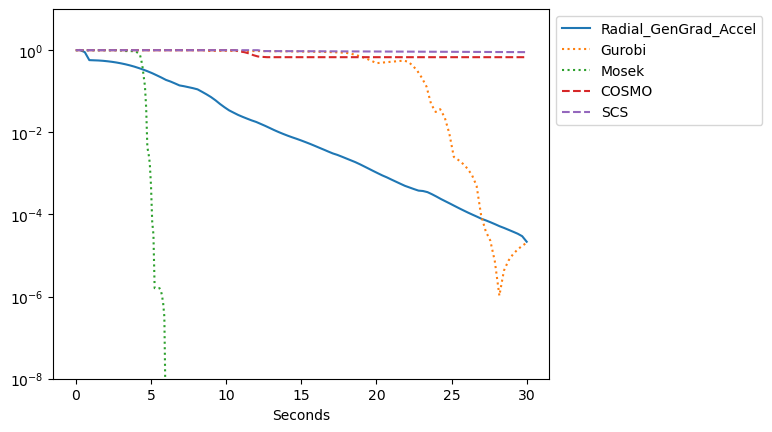

In [922]:
experiment_time = 30
sample = 100
f0 = obj_grad(x0)[1] + 0.5*e'*Q*e.+dot(c,e)

ep1, step1 = radial_accelerate(rad_obj_grad1, rad_obj_grad3 , x0, 440, 0.00044, experiment_time, sample)
ep1 = ep1 .+ 0.5*e'*Q*e.+dot(c,e)
# ep2, step2 = projected_accelerate(obj_grad, proj2, x0, 1100, 19, experiment_time, sample)
# ep2 = ep2 .+ 0.5*e'*Q*e.+dot(c,e)


ep1 = cleanData(ep1)
# ep2 = cleanData(ep2)



PyPlot.semilogy((experiment_time/sample).*(1:sample), (ep1.-r3_long[100000])/(f0-r3_long[100000]), label = "Radial_GenGrad_Accel", linestyle = "solid")
# PyPlot.semilogy((experiment_time/sample).*(1:sample), (ep2.-r1_long[100000])/(f0-r1_long[100000]), label = "ProjGrad_Accel", linestyle = "dashdot")
PyPlot.semilogy(time1, [abs(f1_itp(i)-r3_long[100000])/(f0-r3_long[100000]) for i in time1], label = "Gurobi", linestyle = "dotted")
PyPlot.semilogy(time2, [abs(f2_itp(i)-r3_long[100000])/(f0-r3_long[100000]) for i in time2], label = "Mosek", linestyle = "dotted")
PyPlot.semilogy(time3, [abs(f3_itp(i)-r3_long[100000])/(f0-r3_long[100000]) for i in time3], label = "COSMO", linestyle = "dashed")
PyPlot.semilogy(time4, [abs(f4_itp(i)-r3_long[100000])/(f0-r3_long[100000]) for i in time4], label = "SCS", linestyle = "dashed")


# legend()
legend(bbox_to_anchor=(1.0,1.0))

ylim(1e-8,1e1)
xlabel("Seconds")
# ylabel("Relative Accuracy")
# savefig("ellips_solver_800")
savefig("ellips_solver_1600", bbox_inches="tight")

### p = 4-norm Ellipsoid Constrained Optimization

We implement our radial methods on three different data dimensions (400,200), (800,400), (1600,800), comparing with solvers Gurobi, Mosek, COSMO, SOS.

The following table gives tuned parameters L and $\mu$ of accelerated methods

| Dimension (n,m) | (400, 200) | (800,400) | (1600,800) |
| --- | --- | --- | --- |
| Parameter (L, $\mu$)  |  (7.6,1.2e-3) | (13, 8.6e-4) | (6.7,3.7e-4) |

In [950]:
using Polynomials

# Dimensions
n = 800 
m = 400 

# Generating Random Test Data
x0 = zeros(n)
Random.seed!(123)
P = randn(n,n)
Q = P'*P
c = randn(n,1)

A = randn(m, n)
b = A*randn(n) + 1/m*randn(m)

# Computing a point e in the constraint set
e = conjugate_gradient(A'*A, A'*b, x0, 30)

# Translating original problem by e
b_e = b-A*e
c_e = c+Q*e


# Getting half upper radial squared function and its gradient of constraint
function rad_obj_grad4(x)
    Ax = A*x
    
    w = [0.0,0.0,0.0,0.0,-1.0]
    for i in 1:m
        w[1] += Ax[i]^4 
        w[2] += -4*Ax[i]^3*b_e[i]
        w[3] += 6*Ax[i]^2*b_e[i]^2
        w[4] += -4*Ax[i]*b_e[i]^3
        w[5] += b_e[i]^4
    end
    sol = roots(Polynomial(w))
    
    i_best=1
    val_best = abs(imag(sol[1])) + min(0, -1*real(sol[1]))
    for i in 2:4
        cur = abs(imag(sol[i])) + min(0, -1*real(sol[i]))
        if cur < val_best
            i_best = i
            val_best = cur
        end
    end
    f = real(sol[i_best])
    
    v = (Ax/f-b_e).^3
    zeta = A'*v
    gradf = zeta/dot(zeta, x/f)
    
    if norm(x,2)<=1e-12
        return 0.5*f^2, zeros(n)
    else
        return 0.5*f^2, f*gradf
    end
end




3120.161630184899
0.0002629017811488294


#2145 (generic function with 1 method)

In [21]:
## Getting optimal objective value for (n,m)=(400,200)
# qt_long1, step_long1 = radial_accelerate(rad_obj_grad1, rad_obj_grad4 , x0, 7.6, 0.0012, 100000)
# qt_long1 = qt_long1.+ 0.5*e'*Q*e.+dot(c,e)
# qt_long1 = cleanData(qt_long1)

## Getting optimal objective value for (n,m)=(800,400)
# qt_long2, step_long2 = radial_accelerate(rad_obj_grad1, rad_obj_grad4 , x0, 13, 0.00086, 100000)
# qt_long2 = qt_long2.+ 0.5*e'*Q*e.+dot(c,e)
# qt_long2 = cleanData(qt_long2)

## Getting optimal objective value for (n,m)=(1600,800)
qt_long3, step_long3 = radial_accelerate(rad_obj_grad1, rad_obj_grad4 , x0, 6.7, 0.00037, 100000)
qt_long3 = qt_long3.+ 0.5*e'*Q*e.+dot(c,e)
qt_long3 = cleanData(qt_long3)

LoadError: UndefVarError: rad_obj_grad1 not defined

In [560]:
# Implementing Gurobi
y1 = Variable(n)
Prob = minimize(0.5*quadform(y1,Q; assume_psd=true)+dot(c,y1)-1, norm(A*y1 - b, 4) <= 1)
@time Convex.solve!(Prob, Gurobi.Optimizer)
# z = evaluate(y1)
# Prob.optval



Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-19
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-6267U CPU @ 2.90GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 12008 rows, 13608 columns and 5145612 nonzeros
Model fingerprint: 0xb4434c58
Model has 1602 quadratic constraints
Coefficient statistics:
  Matrix range     [2e-07, 4e+01]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+02]
Presolve removed 4003 rows and 3201 columns (presolve time = 8s) ...
Presolve removed 4003 rows and 3201 columns
Presolve time: 8.54s
Presolved: 8005 rows, 10407 columns, 5136809 nonzeros
Presolved model has 1602 second-order cone constraints
Ordering time: 0.36s

Barrier statistics:
 Free vars  : 2400
 AA' NZ     : 1.025e+07
 Factor NZ  : 1.297e+07 (roughly 110 MB of memory)
 Factor 

┌ Warning: Problem status LOCALLY_SOLVED; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342


In [563]:
radial_accelerate(rad_obj_grad1, rad_obj_grad4 , x0, 6.7, 0.00037, 20, 100)

([-1.0, -128.99751276028675, -1000.5620909731566, -7384.583655339358, -24458.089088342727, -34807.16890273771, -42600.44653551577, -52571.60555938606, -61817.87082344047, -68627.38756037063  …  -313515.62125174905, -313515.62125174905, -313515.6212462927, -313515.621251681, -313515.6212410858, -313515.62125174905, -313515.6212462927, -313515.621251684, -313515.62125174905, -313515.62125174777], 3120)

In [951]:
str1 = 
# "
#    0   5.47504951e+01 -1.52600000e+00  2.24e+04 2.98e+00  5.70e+00     1
#    1  -1.02364055e+02 -4.18143324e-01  2.19e+04 2.89e+00  5.55e+00     1
#    2  -2.00650651e+02  1.50264420e+00  2.11e+04 2.68e+00  5.27e+00     1
#    3  -9.99604701e+01  2.58876419e+00  1.95e+04 2.54e+00  4.97e+00     1
#    4  -2.74522783e+02  1.28483898e+01  1.76e+04 1.74e+00  4.07e+00     1
#    5  -3.12102679e+02  1.59246776e+01  1.11e+04 7.03e-01  2.15e+00     1
#    6  -2.08786866e+02  5.25905190e+01  6.20e+03 1.78e-04  1.77e+00     1
#    7  -1.05079760e+02  1.19361416e+02  3.64e+03 4.29e-05  1.05e+00     1
#    8  -4.26053418e+01  2.17909194e+02  2.51e+03 3.47e-05  7.20e-01     1
#    9  -9.88153110e+00  3.41350476e+02  2.09e+03 2.99e-05  6.16e-01     1
#   10   6.57952947e+00  4.56535796e+02  1.96e+03 2.67e-05  6.22e-01     1
#   11   4.73151482e+01  6.52557952e+02  1.69e+03 2.54e-05  5.60e-01     1
#   12   1.72175452e+02  8.21068675e+02  1.45e+03 2.36e-05  5.84e-01     1
#   13   2.74980906e+02  1.29105160e+03  1.20e+03 2.04e-05  4.69e-01     1
#   14   3.58488611e+02  1.71777818e+03  1.07e+03 1.73e-05  3.84e-01     1
#   15   6.40711903e+02  2.27266003e+03  8.87e+02 1.67e-05  3.04e-01     1
#   16   7.67149883e+02  3.03192429e+03  8.27e+02 1.53e-05  2.54e-01     1
#   17   1.00395320e+03  2.55747568e+03  7.51e+02 1.50e-05  4.17e-01     1
#   18   1.14573132e+03  3.35546862e+03  7.16e+02 1.42e-05  3.81e-01     1
#   19   1.73268911e+03  4.87489543e+03  6.13e+02 1.34e-05  4.21e-01     1
#   20   2.40544985e+03  6.04263841e+03  5.10e+02 1.18e-05  6.01e-01     1
#   21   2.70726481e+03  7.07256392e+03  4.75e+02 1.07e-05  8.82e-01     1
#   22   3.03895985e+03  7.84582028e+03  4.43e+02 1.02e-05  9.23e-01     2
#   23   3.69785001e+03  9.41420100e+03  3.88e+02 9.27e-06  1.20e+00     2
#   24   4.34896712e+03  1.05781426e+04  3.45e+02 8.08e-06  1.57e+00     2
#   25   5.01445166e+03  1.10171202e+04  3.07e+02 7.05e-06  2.17e+00     2
#   26   5.60826644e+03  1.24559309e+04  2.80e+02 6.06e-06  2.98e+00     2
#   27   7.80163247e+03  1.34155044e+04  2.19e+02 4.53e-06  5.54e+00     2
#   28   9.50871666e+03  1.43877496e+04  1.67e+02 3.94e-06  6.70e+00     2
#   29   1.08637024e+04  1.55029015e+04  1.28e+02 2.67e-06  5.68e+00     2
#   30   1.32610805e+04  1.61418519e+04  7.64e+01 2.73e-06  4.27e+00     2
#   31   1.41340039e+04  1.64879701e+04  5.51e+01 1.28e-06  3.14e+00     2
#   32   1.54972295e+04  1.67332167e+04  2.63e+01 8.62e-07  1.63e+00     2
#   33   1.62743006e+04  1.69089595e+04  1.20e+01 6.21e-07  8.56e-01     2
#   34   1.68072194e+04  1.70756141e+04  4.22e+00 3.98e-07  3.84e-01     2
#   35   1.70796150e+04  1.71546291e+04  1.16e+00 2.38e-07  1.41e-01     2
#   36   1.71536118e+04  1.71779745e+04  2.51e-01 2.12e-07  3.55e-02     2
#   37   1.71643379e+04  1.71848652e+04  6.14e-02 1.33e-06  9.02e-03     2
#   38   1.72134715e+04  1.71874579e+04  7.65e-03 1.36e-06  1.45e-03     2
#   39   1.71882097e+04  1.71877592e+04  2.16e-04 5.73e-05  4.50e-05     2
#   40   1.71878628e+04  1.71877772e+04  4.34e-05 4.08e-05  3.29e-06     2
#   41   1.71877786e+04  1.71877772e+04  9.76e-06 1.49e-05  2.28e-07     2
# "
"
   0   1.07303070e+02 -1.52600000e+00  8.68e+04 3.50e+00  1.10e+01     3.67
   1  -2.19359458e+02 -2.67952220e+00  8.50e+04 3.39e+00  1.07e+01     4
   2  -4.22068952e+02 -4.16597397e+00  8.21e+04 3.16e+00  1.02e+01     4.33
   3  -2.64912951e+02 -2.31224671e+00  7.44e+04 3.00e+00  9.45e+00     4.67
   4  -5.96343633e+02 -1.03860236e+00  6.55e+04 1.65e+00  7.02e+00     5
   5  -6.05376850e+02  1.51971914e+01  4.33e+04 6.16e-01  3.78e+00     5.25
   6  -4.01764059e+02  7.58805755e+01  2.26e+04 4.07e-04  3.32e+00     5.50
   7  -1.55476673e+02  2.06708917e+02  1.14e+04 6.68e-05  1.66e+00     5.75
   8  -8.16936361e+01  3.79523039e+02  8.60e+03 5.35e-05  1.26e+00     6
   9  -1.99647005e+01  5.93657773e+02  6.95e+03 4.71e-05  1.02e+00     6.33
  10   7.11093142e+01  1.00594003e+03  5.74e+03 4.25e-05  8.77e-01     6.67
  11   3.09652359e+02  2.24384574e+03  4.91e+03 3.48e-05  1.09e+00     7
  12   6.33168891e+02  3.49112577e+03  3.79e+03 3.07e-05  7.71e-01     7.33
  13   1.22940101e+03  5.75486603e+03  3.13e+03 2.81e-05  7.59e-01     7.67
  14   1.64084891e+03  7.61521473e+03  2.83e+03 2.55e-05  8.23e-01     8
  15   2.71152714e+03  9.58996316e+03  2.49e+03 2.40e-05  1.05e+00     8.33
  16   3.68976304e+03  1.14504068e+04  2.15e+03 2.09e-05  9.53e-01     8.67
  17   4.51435378e+03  1.62491037e+04  1.92e+03 1.91e-05  9.55e-01     9
  18   6.48521481e+03  1.66381534e+04  1.68e+03 1.71e-05  1.48e+00     9.25
  19   9.08130932e+03  2.46985796e+04  1.44e+03 1.45e-05  2.69e+00     9.5
  20   1.07220787e+04  3.17400714e+04  1.29e+03 1.20e-05  3.15e+00     9.75
  21   1.41156525e+04  3.60033494e+04  1.08e+03 9.63e-06  3.93e+00    10
  22   1.73406390e+04  3.91329836e+04  9.13e+02 1.05e-05  3.61e+00    10.25
  23   2.00738958e+04  4.46218889e+04  8.06e+02 7.03e-06  4.64e+00    10.5
  24   2.47536165e+04  4.93741579e+04  6.52e+02 5.67e-06  4.84e+00    10.75
  25   2.76426779e+04  5.24534804e+04  5.69e+02 4.80e-06  4.82e+00    11
  26   3.39228530e+04  5.67149573e+04  4.20e+02 3.55e-06  4.82e+00    11.33
  27   4.05924117e+04  6.08021147e+04  3.06e+02 2.74e-06  4.92e+00    11.67
  28   6.32705513e+04  6.62008376e+04  1.93e+02 2.64e-06  3.56e+00    12
  29   6.41948871e+04  6.69655597e+04  1.43e+02 1.45e-06  2.56e+00    12.33
  30   6.61533063e+04  6.76811738e+04  7.55e+01 1.44e-06  2.02e+00    12.67
  31   7.19146447e+04  6.79496910e+04  5.51e+01 1.86e-06  1.21e+00    13
  32   6.94947232e+04  6.85443227e+04  1.79e+01 1.39e-05  5.39e-01    13.33
  33   6.91022409e+04  6.89613102e+04  6.59e+00 2.32e-05  4.48e-01    13.67
  34   6.93019019e+04  6.93341157e+04  1.33e+00 8.51e-05  4.89e-01    14
  35   6.90792453e+04  6.94103567e+04  6.41e-02 1.12e-03  1.82e-02    14.33
  36   6.94072527e+04  6.94155622e+04  2.10e-03 5.67e-05  2.78e-03    14.67
  37   6.94160773e+04  6.94167439e+04  2.16e-04 5.59e-05  4.41e-04    15
  38   6.94171710e+04  6.94170555e+04  3.12e-07 1.65e-04  9.61e-05    15.5
  39   6.94171333e+04  6.94170664e+04  3.25e-05 3.25e-04  5.97e-05    16
  40   6.94171316e+04  6.94170664e+04  9.11e-04 6.66e-04  5.97e-05    16.5
  41   6.94171316e+04  6.94170664e+04  7.02e-05 1.09e-03  5.97e-05    17
  42   6.94171316e+04  6.94170665e+04  4.67e-04 1.25e-03  5.96e-05    17.5
  43   6.94171316e+04  6.94170665e+04  1.00e-03 1.32e-03  5.96e-05    18
  44   6.94171315e+04  6.94170666e+04  2.09e-03 1.34e-03  5.95e-05    18.5
  45   6.94171589e+04  6.94170833e+04  9.65e-07 1.14e-03  6.29e-05    19
  46   6.94171568e+04  6.94170834e+04  6.52e-04 2.37e-03  6.19e-05    19.5
  47   6.94171531e+04  6.94170835e+04  5.71e-04 4.90e-03  6.01e-05    20
  48   6.94171503e+04  6.94170837e+04  5.04e-04 1.01e-02  5.86e-05    20.5
  49   6.94171332e+04  6.94170875e+04  3.83e-04 1.66e-03  4.48e-05    21
  50   6.94171314e+04  6.94170875e+04  1.28e-04 1.25e-04  4.43e-05    21.5
  51   6.94171297e+04  6.94170875e+04  1.13e-04 2.59e-04  4.39e-05    22
  52   6.94171297e+04  6.94170875e+04  6.41e-04 1.37e-04  4.39e-05    22.5
  53   6.94171297e+04  6.94170875e+04  1.33e-03 4.82e-04  4.40e-05    23
  54   6.94171297e+04  6.94170875e+04  2.76e-03 1.23e-03  4.40e-05    23.5
  55   6.94171296e+04  6.94170875e+04  2.46e-04 3.48e-03  4.40e-05    23
  56   6.94171296e+04  6.94170876e+04  2.85e-04 8.93e-03  4.40e-05    24
  57   6.94171296e+04  6.94170876e+04  2.48e-04 3.22e-02  4.39e-05    24.5
  58   6.94171296e+04  6.94170877e+04  2.82e-04 8.14e-02  4.38e-05    25
  59   6.94171296e+04  6.94170881e+04  2.51e-04 2.06e-01  4.35e-05    25.5

"
# "
#    0   1.52445716e+02 -1.50725000e+00  2.46e+05 7.47e+00  1.56e+01    20
#    1  -4.09221782e+02 -1.60501311e+00  2.44e+05 7.41e+00  1.55e+01    23
#    2  -7.60325884e+02  3.13157063e+00  2.36e+05 6.74e+00  1.49e+01    25
#    3  -1.04107871e+03  1.43632591e+01  1.15e+05 3.69e+00  7.88e+00    27
#    4  -5.58608813e+02  3.91994944e+01  6.64e+04 8.91e-01  3.52e+00    30
# "
Gurobi_obj, Gurobi_time = extract_vectors(str1,2,7)

([107.30307, -219.359458, -422.068952, -264.912951, -596.343633, -605.37685, -401.764059, -155.476673, -81.6936361, -19.9647005  …  69417.1314, 69417.1297, 69417.1297, 69417.1297, 69417.1297, 69417.1296, 69417.1296, 69417.1296, 69417.1296, 69417.1296], [3.67, 4.0, 4.33, 4.67, 5.0, 5.25, 5.5, 5.75, 6.0, 6.33  …  21.5, 22.0, 22.5, 23.0, 23.5, 23.0, 24.0, 24.5, 25.0, 25.5])

In [7]:
using Interpolations
# Gurobi_time = 1.601:0.019:2.38
Gurobi_time = Gurobi_time[1:38]
# Gurobi_time = Gurobi_time[1:5]

# Gurobi_obj = Gurobi_obj[1:42]
Gurobi_obj = Gurobi_obj[1:38]
# Gurobi_obj = Gurobi_obj[1:5]


itp_Gurobi = linear_interpolation(Gurobi_time, Gurobi_obj)

a1 = Gurobi_time[1]
b1 = 15
function f11_itp(x)
    if x>= a1 && x<= b1
        return itp_Gurobi(x)
    end
    if x>=0 && x<a1
        return 0.5*e'*Q*e.+dot(c,e)-1
    end
end
time1= range(0,stop=b1,length=100)

In [834]:
# Implementing Mosek
y2 = Variable(n)
Prob = minimize(0.5*quadform(y2,Q; assume_psd=true)+dot(c,y2)-1, norm(A*y2 - b, 4) <= 1)
@time Convex.solve!(Prob, Mosek.Optimizer)
# z = evaluate(y2)


Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 5604            
  Affine conic cons.     : 1602            
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 7204            
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 3200
Eliminator terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 2                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.06            
Lin. dep.  - number                 : 0               
Presolve te

┌ Warning: Problem status SLOW_PROGRESS; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342


In [953]:
str2 = 
# "
# 0   1.2e+01  3.0e+00  1.5e+00  0.00e+00   -1.000000000e+00  -1.500000000e+00  1.0e+00  0.39  
# 1   4.6e+00  1.1e+00  9.0e-01  -9.98e-01  -4.481385830e-01  7.107982926e-01   3.7e-01  0.43  
# 2   3.3e+00  7.9e-01  7.4e-01  -9.50e-01  4.430216368e-01   2.449254415e+00   2.7e-01  0.45  
# 3   5.6e-01  1.3e-01  2.9e-01  -9.70e-01  4.369422456e+01   6.072729428e+01   4.5e-02  0.48  
# 4   1.5e-01  3.6e-02  1.4e-01  -9.07e-01  4.643542528e+02   5.206136435e+02   1.2e-02  0.51  
# 5   7.4e-02  1.8e-02  8.4e-02  -6.33e-01  1.764145347e+03   1.851032679e+03   5.9e-03  0.53  
# 6   5.2e-02  1.2e-02  4.1e-02  1.64e-01   5.545987627e+03   5.587668036e+03   4.2e-03  0.55  
# 7   2.9e-02  7.0e-03  2.8e-02  -2.37e-01  7.048312508e+03   7.111257774e+03   2.4e-03  0.57  
# 8   1.2e-02  2.9e-03  2.5e-03  1.28e+00   1.452301619e+04   1.452561658e+04   9.9e-04  0.59  
# 9   2.2e-03  5.3e-04  1.3e-04  1.31e+00   1.678461557e+04   1.678482833e+04   1.8e-04  0.60  
# 10  2.6e-04  6.3e-05  1.2e-05  1.38e+00   1.713087047e+04   1.713101103e+04   2.1e-05  0.63  
# 11  4.6e-05  1.1e-05  8.5e-07  1.03e+00   1.718026251e+04   1.718028529e+04   3.7e-06  0.65  
# 12  1.0e-05  2.4e-06  8.6e-08  1.05e+00   1.718589218e+04   1.718589697e+04   8.2e-07  0.71  
# 13  4.3e-06  5.4e-07  9.4e-09  8.99e-01   1.718724914e+04   1.718725033e+04   1.8e-07  0.72  
# 14  6.3e-07  1.5e-07  1.7e-09  9.35e-01   1.718762246e+04   1.718762280e+04   5.0e-08  0.74  
# 15  3.0e-07  1.1e-07  6.7e-10  9.73e-01   1.718770382e+04   1.718770398e+04   2.4e-08  0.78  
# 16  8.3e-08  1.7e-07  1.5e-10  9.73e-01   1.718775725e+04   1.718775730e+04   6.4e-09  0.81  
# 17  1.2e-08  2.4e-07  2.9e-11  9.87e-01   1.718777436e+04   1.718777437e+04   9.4e-10  0.84  
# 18  1.9e-09  7.0e-07  7.2e-12  9.95e-01   1.718777689e+04   1.718777689e+04   1.5e-10  0.88  
# 19  1.9e-09  7.1e-07  2.8e-12  9.98e-01   1.718777689e+04   1.718777689e+04   1.5e-10  0.93  
# 20  1.9e-09  7.1e-07  2.8e-12  9.98e-01   1.718777689e+04   1.718777689e+04   1.5e-10  0.98  
# 21  1.9e-09  7.1e-07  4.3e-14  9.98e-01   1.718777689e+04   1.718777689e+04   1.5e-10  1.04  
# 22  1.9e-09  7.1e-07  4.3e-14  9.98e-01   1.718777689e+04   1.718777689e+04   1.5e-10  1.11  
# 23  1.9e-09  7.1e-07  4.3e-14  9.98e-01   1.718777689e+04   1.718777689e+04   1.5e-10  1.19  
# 24  1.5e-09  1.1e-06  1.1e-12  9.98e-01   1.718777699e+04   1.718777699e+04   1.2e-10  1.24  
# 25  1.5e-09  1.1e-06  1.1e-12  9.98e-01   1.718777699e+04   1.718777699e+04   1.2e-10  1.31  
# 26  1.5e-09  1.1e-06  1.1e-12  9.98e-01   1.718777699e+04   1.718777699e+04   1.2e-10  1.35  
# "
"
0   2.4e+01  3.5e+00  1.5e+00  0.00e+00   -1.000000000e+00  -1.500000000e+00  1.0e+00  2.62  
1   9.3e+00  1.4e+00  9.3e-01  -1.00e+00  -5.325073277e-01  5.566631159e-01   3.9e-01  2.74  
2   6.0e+00  8.7e-01  7.4e-01  -9.96e-01  -2.355416232e-01  2.204917532e+00   2.5e-01  2.82  
3   1.1e+00  1.6e-01  3.1e-01  -9.73e-01  3.594444117e+01   5.528007930e+01   4.6e-02  2.96  
4   4.1e-01  5.9e-02  1.8e-01  -9.49e-01  2.190658251e+02   2.707265641e+02   1.7e-02  3.04  
5   2.4e-01  3.5e-02  1.4e-01  -8.54e-01  4.443723111e+02   5.319341788e+02   9.9e-03  3.11  
6   1.8e-01  2.7e-02  1.1e-01  -7.70e-01  2.429504039e+03   2.518203737e+03   7.6e-03  3.19  
7   5.7e-02  8.2e-03  4.7e-02  -6.81e-01  1.148673014e+04   1.166580632e+04   2.4e-03  3.27  
8   2.9e-02  4.3e-03  1.6e-02  1.36e-01   3.442341543e+04   3.449583728e+04   1.2e-03  3.36  
9   9.2e-03  1.3e-03  1.5e-03  1.59e-01   6.041742944e+04   6.042376108e+04   3.8e-04  3.44  
10  1.6e-03  2.4e-04  1.2e-04  1.39e+00   6.829399127e+04   6.829538710e+04   6.8e-05  3.53  
11  2.1e-04  3.1e-05  7.4e-06  1.15e+00   6.922231291e+04   6.922262647e+04   8.7e-06  3.62  
12  3.7e-05  5.4e-06  4.9e-07  1.07e+00   6.938785211e+04   6.938789664e+04   1.6e-06  3.72  
13  3.6e-06  1.9e-07  1.1e-09  1.06e+00   6.941578214e+04   6.941578310e+04   5.3e-08  3.83  
14  2.5e-06  1.3e-07  7.8e-10  9.74e-01   6.941622208e+04   6.941622278e+04   3.6e-08  3.99  
15  7.4e-07  1.7e-07  1.8e-10  9.43e-01   6.941694482e+04   6.941694499e+04   7.7e-09  4.12  
16  7.4e-07  1.7e-07  1.8e-10  9.43e-01   6.941694482e+04   6.941694499e+04   7.7e-09  4.26  
17  7.4e-07  1.7e-07  1.5e-10  9.85e-01   6.941694513e+04   6.941694530e+04   7.7e-09  4.40  
18  7.4e-07  1.7e-07  1.0e-10  9.95e-01   6.941694513e+04   6.941694530e+04   7.7e-09  4.54  
19  7.0e-07  1.6e-07  7.5e-12  9.80e-01   6.941695492e+04   6.941695508e+04   7.3e-09  4.67  
20  7.0e-07  1.6e-07  7.5e-12  9.80e-01   6.941695492e+04   6.941695508e+04   7.3e-09  4.80  
21  7.0e-07  1.6e-07  7.5e-12  9.80e-01   6.941695492e+04   6.941695508e+04   7.3e-09  4.97  
"
# "
# 0   3.4e+01  3.7e+00  1.5e+00  0.00e+00   -1.000000000e+00  -1.500000000e+00  1.0e+00  18.37 
# 1   1.3e+01  1.4e+00  9.3e-01  -1.00e+00  -5.297954908e-01  5.606732233e-01   3.9e-01  18.76 
# 2   8.3e+00  9.1e-01  7.3e-01  -9.99e-01  -1.933988809e-02  2.522858028e+00   2.4e-01  19.15 
# 3   3.2e+00  3.5e-01  4.5e-01  -9.86e-01  6.277380244e+00   1.520668442e+01   9.3e-02  19.54 
# 4   1.0e+00  1.1e-01  2.6e-01  -9.86e-01  6.522135319e+01   9.531194794e+01   3.0e-02  19.95 
# 5   4.8e-01  5.3e-02  1.7e-01  -9.62e-01  1.931276917e+02   2.594392285e+02   1.4e-02  20.34 
# 6   3.8e-01  4.2e-02  1.5e-01  -9.32e-01  1.096593072e+03   1.174982482e+03   1.1e-02  20.69 
# 7   1.1e-01  1.2e-02  7.5e-02  -9.02e-01  6.100383903e+03   6.338293069e+03   3.2e-03  21.08 
# 8   4.9e-02  5.4e-03  4.4e-02  -7.29e-01  2.555150214e+04   2.597561930e+04   1.4e-03  21.44 
# 9   3.7e-02  4.0e-03  2.2e-02  2.61e-01   9.182451284e+04   9.200601770e+04   1.1e-03  21.80 
# 10  2.0e-02  2.2e-03  1.5e-02  -3.05e-01  1.191722975e+05   1.194601197e+05   5.9e-04  22.15 
# 11  8.6e-03  9.4e-04  1.5e-03  1.52e+00   2.479573411e+05   2.479721397e+05   2.5e-04  22.51 
# 12  1.7e-03  1.9e-04  1.1e-04  1.29e+00   2.833670325e+05   2.833691110e+05   5.1e-05  22.87 
# 13  1.6e-04  1.7e-05  2.5e-06  1.43e+00   2.903727840e+05   2.903729041e+05   4.7e-06  23.44 
# 14  2.2e-05  2.4e-06  2.8e-07  1.06e+00   2.910952343e+05   2.910953153e+05   6.4e-07  23.86 
# 15  8.3e-06  9.1e-07  5.3e-08  1.06e+00   2.911714653e+05   2.911714955e+05   2.4e-07  24.47 
# 16  1.7e-06  1.9e-07  1.4e-08  5.66e-01   2.911945547e+05   2.911945661e+05   5.6e-08  25.04 
# 17  6.2e-07  1.7e-07  7.0e-09  6.35e-01   2.912047137e+05   2.912047191e+05   1.9e-08  25.58 
# 18  5.6e-07  2.0e-07  4.0e-09  6.62e-01   2.912058882e+05   2.912058930e+05   1.6e-08  26.16 
# 19  5.6e-07  2.0e-07  4.0e-09  6.62e-01   2.912058882e+05   2.912058930e+05   1.6e-08  26.83 
# 20  3.7e-07  2.3e-07  9.9e-10  7.29e-01   2.912084216e+05   2.912084250e+05   1.1e-08  27.38 
# 21  1.4e-07  4.6e-07  2.6e-10  7.71e-01   2.912123996e+05   2.912124009e+05   3.4e-09  27.94 
# 22  1.2e-07  5.5e-07  8.0e-11  8.67e-01   2.912127563e+05   2.912127574e+05   2.9e-09  28.50 
# 23  1.2e-07  5.5e-07  8.0e-11  8.67e-01   2.912127563e+05   2.912127574e+05   2.9e-09  29.16 
# 24  1.2e-07  5.5e-07  3.7e-11  8.63e-01   2.912127565e+05   2.912127576e+05   2.9e-09  29.78 
# 25  1.2e-07  5.5e-07  3.7e-11  8.63e-01   2.912127565e+05   2.912127576e+05   2.9e-09  30.43 
# 26  1.2e-07  5.5e-07  3.7e-11  8.63e-01   2.912127565e+05   2.912127576e+05   2.9e-09  31.15 
# "
Mosek_obj, Mosek_time = extract_vectors(str2, 6, 9)

([-1.0, -0.5325073277, -0.2355416232, 35.94444117, 219.0658251, 444.3723111, 2429.504039, 11486.73014, 34423.41543, 60417.42944  …  69387.85211, 69415.78214, 69416.22208, 69416.94482, 69416.94482, 69416.94513, 69416.94513, 69416.95492, 69416.95492, 69416.95492], [2.62, 2.74, 2.82, 2.96, 3.04, 3.11, 3.19, 3.27, 3.36, 3.44  …  3.72, 3.83, 3.99, 4.12, 4.26, 4.4, 4.54, 4.67, 4.8, 4.97])

In [8]:
itp_mosek = linear_interpolation(Mosek_time, Mosek_obj)
a2 = Mosek_time[1]
b2 = 4.97

function f12_itp(x)
    if x>= a2 && x<= b2
        return itp_mosek(x) 
    end
    if x>=0 && x<a2
        return 0.5*e'*Q*e.+dot(c,e)-1
    end
end
time2= range(0,stop=b2,length=100)


In [572]:
# Implementing COSMO
y3 = Variable(n)
Prob = minimize(0.5*quadform(y3,Q; assume_psd=true)+dot(c,y3)-1, norm(A*y3 - b, 4) <= 1)
@time Convex.solve!(Prob, MOI.OptimizerWithAttributes(COSMO.Optimizer, "time_limit"=>30.0))
# z = evaluate(y3)

------------------------------------------------------------------
          COSMO v0.8.6 - A Quadratic Objective Conic Solver
                         Michael Garstka
                University of Oxford, 2017 - 2022
------------------------------------------------------------------

Problem:  x ∈ R^{7204},
          constraints: A ∈ R^{12008x7204} (5139208 nnz),
          matrix size to factor: 19212x19212,
          Floating-point precision: Float64
Sets:     Nonnegatives of dim: 3203
          ZeroSet of dim: 2401
          SecondOrderCone of dim: 1601
          SecondOrderCone of dim: 3
          SecondOrderCone of dim: 3
          ... and 1599 more
Settings: ϵ_abs = 1.0e-05, ϵ_rel = 1.0e-05,
          ϵ_prim_inf = 1.0e-04, ϵ_dual_inf = 1.0e-04,
          ρ = 0.1, σ = 1e-06, α = 1.6,
          max_iter = 5000,
          scaling iter = 10 (on),
          check termination every 25 iter,
          check infeasibility every 40 iter,
          KKT system solver: QDLDL
Acc:      Anders

┌ Warning: Problem status TIME_LIMIT; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342


In [955]:
str3 =
# "
# 1	-1.7545e+02	1.8929e+02	2.3859e+00	1.0000e-01
# 25	 9.6757e+01	3.3650e+01	6.6325e-01	1.0000e-01
# 50	 1.9456e+02	3.1971e+01	8.3997e-01	1.0000e-01
# 75	 4.2972e+02	2.3540e+01	1.0707e+00	1.0000e-01
# 100	 9.8504e+02	1.3495e+01	1.0849e+00	9.0241e-03
# 125	 2.5181e+03	8.5916e+01	9.0351e-01	8.7076e-04
# 150	 2.7238e+03	2.1406e+01	4.9917e-03	8.7076e-04
# 175	 2.6511e+03	1.9382e+01	8.4604e-03	8.7076e-04
# 200	 2.6282e+03	1.7381e+01	2.7728e-03	8.7076e-04
# 225	 2.2922e+03	7.2310e+00	3.0677e-03	8.7076e-04
# 250	 2.2136e+03	6.9116e+00	3.3686e-03	8.7076e-04
# 275	 1.8787e+03	1.4950e+01	3.5441e-03	8.7076e-04
# 300	 1.9074e+03	1.2476e+01	1.9271e-03	8.7076e-04
# 325	 2.0175e+03	7.9001e+00	2.8428e-03	8.7076e-04
# 350	 2.1039e+03	6.4846e+00	4.5368e-03	8.7076e-04
# 375	 2.2197e+03	6.8677e+00	3.7088e-03	8.7076e-04
# 400	 2.2948e+03	7.0755e+00	5.0263e-04	8.7076e-04
# 425	 2.0683e+03	7.1822e+00	8.1479e-04	8.7076e-04
# 450	 2.0318e+03	9.4851e+00	4.2070e-03	8.7076e-04
# 475	 1.9932e+03	1.0969e+01	1.6229e-03	8.7076e-04
# 500	 1.9726e+03	1.2032e+01	1.2803e-03	8.7076e-04
# 525	 2.0297e+03	9.6359e+00	1.6443e-03	8.7076e-04
# 550	 2.1451e+03	6.3837e+00	1.4791e-03	8.7076e-04
# 575	 2.2168e+03	6.6008e+00	3.4950e-03	8.7076e-04
# 600	 2.2325e+03	6.6156e+00	2.3559e-03	8.7076e-04
# 625	 2.2214e+03	6.5474e+00	1.0978e-03	8.7076e-04
# 650	 2.1717e+03	6.3394e+00	1.8162e-03	8.7076e-04
# 675	 2.0979e+03	8.2302e+00	3.1528e-03	8.7076e-04
# 700	 2.0552e+03	9.9465e+00	7.8615e-03	8.7076e-04
# 725	 2.0206e+03	1.1436e+01	1.3155e-03	8.7076e-04
# 750	 2.0292e+03	1.1051e+01	1.6904e-03	8.7076e-04
# 775	 2.0465e+03	1.0378e+01	1.1278e-03	8.7076e-04
# 800	 2.0657e+03	9.6452e+00	1.4141e-03	8.7076e-04
# 825	 2.1364e+03	6.9655e+00	1.6972e-03	8.7076e-04
# 850	 2.2062e+03	6.3674e+00	1.5920e-03	8.7076e-04
# 875	 2.2660e+03	6.5333e+00	7.4715e-04	8.7076e-04
# 900	 2.2858e+03	6.5636e+00	2.5431e-04	8.7076e-04
# 925	 2.2702e+03	6.4850e+00	9.6082e-04	8.7076e-04
# 950	 2.2545e+03	6.4175e+00	1.3004e-03	8.7076e-04
# 975	 2.2357e+03	6.3423e+00	1.5037e-03	8.7076e-04
# 1000	 2.2076e+03	6.2341e+00	1.6610e-03	8.7076e-04
# 1025	 2.1881e+03	6.1595e+00	1.7492e-03	8.7076e-04
# 1050	 2.1547e+03	7.3584e+00	1.7625e-03	8.7076e-04
# 1075	 2.1189e+03	8.8182e+00	1.5845e-03	8.7076e-04
# 1100	 2.0842e+03	1.0220e+01	1.1941e-03	8.7076e-04
# 1125	 2.0647e+03	1.1010e+01	7.0784e-04	8.7076e-04
# 1150	 2.0555e+03	1.1369e+01	9.6104e-05	8.7076e-04
# 1175	 2.0601e+03	1.1201e+01	3.2467e-04	8.7076e-04
# 1200	 2.0639e+03	1.1063e+01	5.0803e-04	8.7076e-04
# 1225	 2.0795e+03	1.0463e+01	8.7497e-04	8.7076e-04
# 1250	 2.0781e+03	1.0520e+01	7.5152e-04	8.7076e-04
# 1275	 2.1354e+03	8.3878e+00	1.2172e-03	8.7076e-04
# 1300	 2.1502e+03	7.8276e+00	1.3237e-03	8.7076e-04
# 1325	 2.1763e+03	6.8563e+00	1.4055e-03	8.7076e-04
# 1350	 2.2154e+03	6.1662e+00	1.3562e-03	8.7076e-04
# 1375	 2.2681e+03	6.3141e+00	9.9796e-04	8.7076e-04
# 1400	 2.2941e+03	6.3723e+00	3.5801e-04	8.7076e-04
# 1425	 2.2972e+03	6.3605e+00	2.1600e-04	8.7076e-04
# 1450	 2.2894e+03	6.3206e+00	5.7296e-04	8.7076e-04
# 1475	 2.2776e+03	6.2672e+00	8.8462e-04	8.7076e-04
# 1500	 2.2634e+03	6.2083e+00	1.1082e-03	8.7076e-04
# 1525	 2.2526e+03	6.1663e+00	1.2178e-03	8.7076e-04
# "
"
1	-5.1558e+02	3.5118e+02	2.7987e+00	1.0000e-01
25	 1.2032e+02	7.1752e+01	1.6367e+00	1.0000e-01
50	 3.3641e+02	5.9305e+01	1.3603e+00	1.8630e-02
75	 1.5090e+03	1.7387e+01	5.8378e-01	1.8630e-02
100	 3.2391e+03	7.2540e+01	4.6449e-01	2.2033e-03
125	 8.7372e+03	3.4106e+02	2.7867e-01	2.2033e-03
150	 1.1524e+04	3.5348e+02	2.0438e-01	3.3369e-04
175	 8.0850e+03	1.8570e+02	1.3618e-02	3.3369e-04
200	 6.2872e+03	1.0227e+02	1.3617e-02	3.3369e-04
225	 5.1151e+03	5.0923e+01	1.8082e-02	3.3369e-04
250	 2.8000e+03	5.0440e+01	7.6839e-03	3.3369e-04
275	 2.1270e+03	7.9831e+01	4.7224e-03	3.3369e-04
300	 1.9512e+03	8.7901e+01	1.3715e-03	3.3369e-04
325	 1.9359e+03	8.8472e+01	5.1266e-03	1.8398e-03
350	 1.9642e+03	8.6715e+01	9.3306e-03	1.8398e-03
375	 2.0110e+03	8.4293e+01	1.4571e-02	1.8398e-03
400	 2.1860e+03	7.6021e+01	2.0581e-02	1.8398e-03
425	 2.2833e+03	7.1420e+01	2.4131e-02	1.8398e-03
450	 2.3803e+03	6.7166e+01	2.1382e-02	1.8398e-03
475	 3.1009e+03	3.8733e+01	5.1096e-03	1.8398e-03
500	 3.1897e+03	3.5933e+01	4.4572e-03	1.8398e-03
525	 3.1984e+03	3.5573e+01	3.4389e-03	1.8398e-03
550	 3.2103e+03	3.5290e+01	1.0470e-02	1.8398e-03
575	 3.2359e+03	3.4016e+01	4.7870e-03	1.8398e-03
600	 3.2686e+03	3.2377e+01	6.3739e-03	1.8398e-03
625	 3.3109e+03	3.0148e+01	7.6880e-03	1.8398e-03
650	 3.3555e+03	2.7997e+01	8.6129e-03	1.8398e-03
675	 3.4120e+03	2.4686e+01	9.2485e-03	1.8398e-03
700	 3.4786e+03	2.1740e+01	9.5393e-03	1.8398e-03
725	 3.5436e+03	1.9465e+01	9.3850e-03	1.8398e-03
750	 3.6055e+03	1.5384e+01	8.8183e-03	1.8398e-03
775	 3.6635e+03	1.3368e+01	9.9133e-03	1.8398e-03
800	 3.7238e+03	1.3200e+01	6.0840e-03	1.8398e-03
825	 3.7756e+03	1.3198e+01	8.8610e-03	1.8398e-03
850	 3.7955e+03	1.3151e+01	6.3964e-03	1.8398e-03
875	 3.8025e+03	1.3029e+01	1.8047e-03	1.8398e-03
900	 3.7943e+03	1.2866e+01	3.1094e-03	1.8398e-03
925	 3.7674e+03	1.2592e+01	1.0095e-02	1.8398e-03
950	 3.7186e+03	1.2260e+01	6.4523e-03	1.8398e-03
975	 3.6618e+03	1.2280e+01	7.7870e-03	1.8398e-03
1000	 3.5786e+03	1.3969e+01	8.8069e-03	1.8398e-03
1025	 3.4861e+03	1.8119e+01	9.2170e-03	1.8398e-03
1050	 3.4337e+03	1.9202e+01	8.9931e-03	1.8398e-03
1075	 3.3493e+03	2.0557e+01	8.2846e-03	1.8398e-03
1100	 3.2489e+03	2.5074e+01	6.7743e-03	1.8398e-03
1125	 3.1737e+03	2.5266e+01	4.6936e-03	1.8398e-03
1150	 3.1363e+03	2.6229e+01	2.0974e-03	1.8398e-03
1175	 3.1271e+03	2.7773e+01	7.0373e-04	1.8398e-03
1200	 3.1334e+03	2.7135e+01	1.3108e-03	1.8398e-03
1225	 3.1435e+03	2.6396e+01	1.9639e-03	1.8398e-03
1250	 3.1457e+03	2.6582e+01	2.1101e-03	1.8398e-03
1275	 3.1536e+03	2.7296e+01	2.0620e-03	1.8398e-03
1300	 3.3491e+03	1.9084e+01	2.2958e-03	1.8398e-03
1325	 3.3579e+03	2.1029e+01	2.9057e-03	1.8398e-03
1350	 3.3941e+03	1.9830e+01	3.5482e-03	1.8398e-03
1375	 3.4646e+03	1.8118e+01	4.4657e-03	1.8398e-03
1400	 3.5615e+03	1.6554e+01	5.0028e-03	1.8398e-03
1425	 3.6236e+03	1.4231e+01	4.7055e-03	1.8398e-03
1450	 3.6640e+03	1.3036e+01	4.2627e-03	1.8398e-03
1475	 3.7046e+03	1.4012e+01	3.5794e-03	1.8398e-03
1500	 3.7477e+03	1.1359e+01	2.5786e-03	1.8398e-03
1525	 3.7754e+03	1.1745e+01	1.7136e-03	1.8398e-03
1550	 3.7998e+03	1.2827e+01	2.2295e-03	1.8398e-03
1575	 3.8000e+03	1.1748e+01	9.0607e-04	1.8398e-03
1600	 3.7907e+03	1.3953e+01	1.1016e-03	1.8398e-03
1625	 3.7571e+03	1.6200e+01	2.4556e-03	1.8398e-03
1650	 3.7221e+03	1.6373e+01	2.0492e-03	1.8398e-03
1675	 3.7063e+03	1.7658e+01	1.5872e-03	1.8398e-03

"
# "
# 1	-5.7161e+02	6.5538e+02	2.9893e+00	1.0000e-01
# 25	 3.1086e+02	1.6516e+02	3.6274e+00	1.0000e-01
# 50	 5.4373e+02	1.3152e+02	2.0810e+00	1.0000e-01
# 75	 8.7295e+02	1.3852e+02	2.5317e+00	1.0000e-01
# 100	 1.6336e+03	1.0735e+02	2.8840e+00	1.1201e-02
# 125	 6.0216e+03	2.4246e+02	9.2828e-01	8.0328e-04
# "
COSMO_obj, notUsed = extract_vectors(str3, 2, 3)

([-515.58, 120.32, 336.41, 1509.0, 3239.1, 8737.2, 11524.0, 8085.0, 6287.2, 5115.1  …  3664.0, 3704.6, 3747.7, 3775.4, 3799.8, 3800.0, 3790.7, 3757.1, 3722.1, 3706.3], [351.18, 71.752, 59.305, 17.387, 72.54, 341.06, 353.48, 185.7, 102.27, 50.923  …  13.036, 14.012, 11.359, 11.745, 12.827, 11.748, 13.953, 16.2, 16.373, 17.658])

In [10]:
# COSMO_time = range(0.202,stop=3.0,length=62)
COSMO_time = range(1.905,stop=15,length=68)
# COSMO_time = range(5,stop=30,length=6)

# COSMO_obj = COSMO_obj[1:62]
COSMO_obj = COSMO_obj[1:68]
# COSMO_obj = COSMO_obj[1:6]

itp_COSMO = linear_interpolation(COSMO_time, COSMO_obj)
# f3_itp = x-> itp_COSMO(x) -r1_long[100000]
a3 = COSMO_time[1]
b3 = 15
function f13_itp(x)
    if x>= a3 && x<= b3
        return itp_COSMO(x)
    end
    if x>=0 && x<a3
        return 0.5*e'*Q*e.+dot(c,e)-1
    end
end
time3= range(0,stop=b3,length=100)

In [575]:
# Implementing SCS
y4 = Variable(n)
Prob = minimize(0.5*quadform(y4,Q; assume_psd=true)+dot(c,y4)-1, norm(A*y4 - b, 4) <= 1)
@time Convex.solve!(Prob, SCS.Optimizer)
# z = evaluate(y3)

606.405528 seconds (1.39 M allocations: 1.290 GiB, 0.02% gc time)
------------------------------------------------------------------
	       SCS v3.2.1 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 7204, constraints m: 12008
cones: 	  z: primal zero / dual free vars: 2401
	  l: linear vars: 3203
	  q: soc vars: 6404, qsize: 1602
settings: eps_abs: 1.0e-04, eps_rel: 1.0e-04, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 10, acceleration_interval: 10
lin-sys:  sparse-direct-amd-qdldl
	  nnz(A): 5139208, nnz(P): 0
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 8.00e+02  3.74e+00  2.18e+03  8.78e+01  1.00e-01  2

In [957]:
str4 =
# "
#      0| 2.64e+02  2.98e+00  5.85e+02 -1.17e+02  1.00e-01  2.94e-01 
#    250| 9.13e+00  1.71e-01  1.22e+01  3.93e+03  2.25e-03  9.18e-01 
#    500| 3.16e+01  9.03e-05  8.05e-02  5.99e+03  2.10e-04  1.41e+00 
#    750| 3.20e+01  4.67e-05  3.50e-02  6.01e+03  2.10e-04  1.78e+00 
#   1000| 3.16e+01  2.11e-03  2.89e-01  6.12e+03  2.43e-03  2.40e+00 
#   1250| 3.08e+01  1.69e-03  2.69e-01  6.32e+03  2.43e-03  2.77e+00 
#   1500| 2.98e+01  1.65e-03  4.58e-01  6.50e+03  2.43e-03  3.14e+00 
#   1750| 7.79e+02  1.49e+00  4.49e-01  7.57e+03  2.43e-03  3.50e+00 
#   2000| 2.76e+01  1.98e-03  5.55e-01  6.77e+03  2.43e-03  3.87e+00 
#   2250| 2.64e+01  2.04e-03  4.95e-01  6.89e+03  2.43e-03  4.24e+00 
#   2500| 2.53e+01  2.04e-03  4.46e-01  6.99e+03  2.43e-03  4.60e+00 
#   2750| 2.42e+01  2.01e-03  4.16e-01  7.09e+03  2.43e-03  4.97e+00 
#   3000| 2.32e+01  1.98e-03  3.92e-01  7.17e+03  2.43e-03  5.34e+00 
#   3250| 2.21e+01  1.93e-03  3.71e-01  7.24e+03  2.43e-03  5.70e+00 
#   3500| 1.36e+01  1.16e-03  3.23e+00  7.69e+03  2.43e-03  6.07e+00 
#   3750| 1.30e+01  1.57e-03  1.67e+00  7.70e+03  2.43e-03  6.43e+00 
#   4000| 1.25e+01  1.70e-03  8.28e-01  7.72e+03  2.43e-03  6.80e+00 
#   4250| 1.20e+01  1.51e-03  4.45e-01  7.75e+03  2.43e-03  7.16e+00 
#   4500| 1.15e+01  1.34e-03  2.75e-01  7.77e+03  2.43e-03  7.52e+00 
#   4750| 1.78e+00  2.20e-03  7.41e-01  8.06e+03  2.43e-03  7.89e+00 
#   4800| 1.26e+00  1.08e-05  5.36e-01  8.08e+03  2.43e-03  7.97e+00 
# "
"
     0| 4.58e+02  3.50e+00  1.23e+03 -2.74e+02  1.00e-01  1.70e+00 
   250| 9.97e+01  1.51e-01  3.54e+02  1.28e+04  2.35e-03  4.91e+00 
   500| 2.04e+02  8.74e-03  7.54e+01  1.07e+04  1.01e-04  8.09e+00 
   750| 6.23e+01  8.65e-06  5.48e-02  1.05e+04  1.01e-04  9.39e+00 
  1000| 6.36e+01  4.98e-04  9.05e-01  1.07e+04  3.44e-04  1.17e+01 
  1250| 7.00e+01  4.92e-03  4.18e+00  1.15e+04  1.10e-03  1.40e+01 
  1500| 7.50e+01  3.25e-03  4.03e+00  1.23e+04  1.10e-03  1.52e+01 
"

# "
#      0| 8.00e+02  3.74e+00  2.18e+03  8.78e+01  1.00e-01  2.19e+01 
#    250| 7.15e+19  1.20e+17  8.71e+20  4.22e+21  2.66e-03  6.71e+01 
#    500| 5.08e+02  4.20e-02  2.88e+02  1.89e+04  7.87e-05  1.14e+02
# "

SCS_obj, SCS_time = extract_vectors(str4, 5, 7)

([-274.0, 12800.0, 10700.0, 10500.0, 10700.0, 11500.0, 12300.0], [1.7, 4.91, 8.09, 9.39, 11.7, 14.0, 15.2])

In [12]:
# SCS_obj = SCS_obj[1:7]
SCS_obj = [-274.0, 12800.0, 10700.0, 10500.0, 10700.0, 11500.0, 12300.0]
# SCS_obj = [87.8, 18900.0]

# SCS_obj = cleanData(-1*SCS_obj)*-1


# SCS_time = SCS_time[1:7]
SCS_time = [1.7, 4.91, 8.09, 9.39, 11.7, 14.0, 15.2]
# SCS_time = [21.9, 114.0]

itp_SCS = linear_interpolation(SCS_time, SCS_obj)
# f4_itp = x-> itp_SCS(x) -r1_long[100000]
a4 = SCS_time[1]
b4 = 15
function f14_itp(x)
    if x>= a4 && x<= b4
        return itp_SCS(x)
    end
    if x>=0 && x<a4
        return 0.5*e'*Q*e.+dot(c,e)-1
    end
end
time4= range(0,stop=b4,length=100)

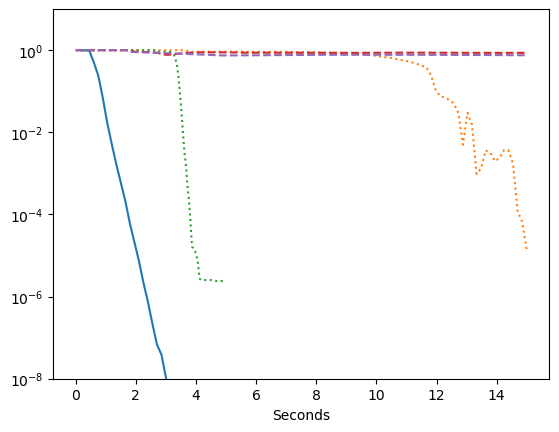

In [960]:
experiment_time = 15
sample = 100
f0 = obj_grad(x0)[1] + 0.5*e'*Q*e.+dot(c,e)


qt1, step1 = radial_accelerate(rad_obj_grad1, rad_obj_grad4 , x0, 13, 0.00086, experiment_time, sample)
qt1 =qt1 .+ 0.5*e'*Q*e.+dot(c,e)
# # proj_accu = 1e-3
# # qt2, step2 = projected_accelerate(obj_grad, proj3, x0, 1700, 0.00036, experiment_time, sample)
# # proj_accu=1e-6
# # qt3, step3 = projected_accelerate(obj_grad, proj3, x0, 1700, 0.00036, experiment_time, sample)
# # proj_accu=1e-9
# # qt4, step4 = projected_accelerate(obj_grad, proj3, x0, 1700, 0.00036, experiment_time, sample)

qt1 = cleanData(qt1)
# qt2 = cleanData(qt2)
# qt3 = cleanData(qt3)
# qt4 = cleanData(qt4)
PyPlot.semilogy((experiment_time/sample).*(1:sample), (qt1.-qt_long2[100000])/(f0-qt_long2[100000]), label = "Radial_GenGrad_Accel")
PyPlot.semilogy(time1, [abs(f11_itp(i)-qt_long2[100000])/(f0-qt_long2[100000]) for i in time1], label = "Gurobi", linestyle = "dotted")
PyPlot.semilogy(time2, [abs(f12_itp(i)-qt_long2[100000])/(f0-qt_long2[100000]) for i in time2], label = "Mosek", linestyle = "dotted")
PyPlot.semilogy(time3, [abs(f13_itp(i)-qt_long2[100000])/(f0-qt_long2[100000]) for i in time3], label = "COSMO", linestyle = "dashed")
PyPlot.semilogy(time4, [abs(f14_itp(i)-qt_long2[100000])/(f0-qt_long2[100000]) for i in time4], label = "SCS", linestyle = "dashed")
# legend(bbox_to_anchor=(1.0,1.0))

ylim(1e-8,1e1)
xlabel("Seconds")
# ylabel("Relative Accuracy")
savefig("quartic_solver_800")
# savefig("quartic_solver_1600", bbox_inches="tight")

